# Initiate

##  Requirements 

In [1]:
import gymnasium as gym
import numpy as np
import copy
from copy import deepcopy
import random 
import pickle
import sklearn
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score
import time
import logging
from datetime import datetime
from stable_baselines3 import DQN
import pickle
from math import ceil
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## RL

In [2]:

class StoreAndTerminateWrapper(gym.Wrapper):
    '''
    :param env: (gym.Env) Gym environment that will be wrapped
    :param max_steps: (int) Max number of steps per episode
    '''
    def __init__(self, env):
        super().__init__(env)
        self.max_steps = 200
        self.current_step = 0
        self.env=env
        self.mem = []
        self.TotalReward = 0.0
        self.first_state = 0
        self.first_obs = 0
        self.prev_obs = 0
        self.states_list = []
        self.info = {}

    def reset(self, *args, **kwargs):
        self.current_step = 0
        obs, info = self.env.reset(*args, **kwargs)
        self.TotalReward = 0.0
        self.first_obs = obs
        return obs,info

    def step(self, action):
        if self.current_step == 0:
            self.prev_obs = self.first_obs
            self.first_state = deepcopy(self.env)
            self.states_list.append(self.first_state)
        self.current_step += 1
        obs, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        self.TotalReward += reward
        self.mem.append(tuple((self.prev_obs,action)))
        self.prev_obs = obs
        if self.current_step >= self.max_steps:
            done = True
        if obs[0] <= -1.2:
            done = True
            reward = -201 - self.TotalReward
            self.TotalReward = -200
        if done:
            self.mem.append(tuple(('done',self.TotalReward)))
        self.info['mem'] = self.mem
        self.info['state'] = self.states_list
        return obs, reward, terminated, truncated, info

    def set_state(self, state):
        self.env = deepcopy(state)
        obs = np.array(list(self.env.unwrapped.state))
        self.current_step = 0
        self.TotalReward = 0.0
        self.first_obs = obs
        return obs

def proportional_sampling_whitout_replacement(index , size):
  s=0
  s = sum(np.array(index))
  p = [ind/s for ind in index]
  samples = np.random.choice(index,size=size,replace=False,p=p)
  return samples


def population_sample(episodes , ind,  pop_size , threshold, functional_fault_size, reward_fault_size):
  """
  This function is meant to sample episodes from training after that you need to add test episodes using random_test 
  Set the parameters as you want but be careful the input episodes for this function is the memory of the agent and each step has seperate index 
  this function returns the final steps of the selected function then you need to extract that episodes from the input memore that is called 'episodes'
  use the episodes extract function ... 

  samples n episodes from training n1 functinal faults and n2 reward faults 
  reward faults are episodes with reward bellow the thresthreshold 
  from random test samples M episodes m1 random episode and
  m2 episodes with sudden reward change we dont have a sudden reward change in this example  
  """
  epsilon = 0.1
  index = []
  functional_fault = []
  reward_fault = []
  start_states =[]
  ind  = np.where(np.array(episodes)==('done',))
  index= ind[0]
  print(len(ind[0]),'episodes from training')
  population=[]
  for i in index:
    _,r = episodes[i]
    if abs(episodes[i-1][0][0])<(mtc_wrapped.low[0]+epsilon):
      functional_fault.append(i)
      print('function fault') 
    if r<threshold:
      reward_fault.append(i)
      print('reward fault')
  if len(functional_fault)<functional_fault_size:
    print('functional faults size is' ,len(functional_fault),' and its less than desired number' )
    population += functional_fault
    print('sampling more random episodes instead ...!')
  if len(functional_fault)==functional_fault_size:
    population += functional_fault
  if len(functional_fault)>functional_fault_size:
    # proportianl_sample_whitout_replacement()
    sam1=proportional_sampling_whitout_replacement(functional_fault,functional_fault_size)
    print(population)
    print("ff",len(functional_fault))
    population += sam1
  if len(reward_fault)<reward_fault_size:
    print('reward faults size is' ,len(reward_fault),' and its less than desired number' )
    population += reward_fault
    print('sampling more random episodes instead ...!')
  if len(reward_fault)==reward_fault_size:
    population += reward_fault
  if len(reward_fault)>reward_fault_size:
    #proportional sampling
    sam2 = proportional_sampling_whitout_replacement(reward_fault,reward_fault_size)
    population += list(sam2)
  r_size= pop_size-len(population)
  # random_test(model,env,r_size)
  print("RF",len(reward_fault))
  # population += reward_fault
  return population , r_size


def population_sample_generalaized(episodes ,  pop_size , threshold, functional_fault_size, reward_fault_size):
  """
  This function is meant to sample episodes from training after that you need to add test episodes using random_test 
  Set the parameters as you want but be careful the input episodes for this function is the memory of the agent and each step has seperate index 
  this function returns the final steps of the selected function then you need to extract that episodes from the input memore that is called 'episodes'
  use the episodes extract function ... 

  samples n episodes from training n1 functinal faults and n2 reward faults 
  reward faults are episodes with reward bellow the thresthreshold 
  from random test samples M episodes m1 random episode and
  m2 episodes with sudden reward change we dont have a sudden reward change in this example  
  """
  epsilon = 0.1
  index = []
  functional_fault = []
  reward_fault = []
  start_states =[]
  ind  = np.where(np.array(episodes)==('done',))
  index= ind[0]
  print(len(ind[0]),'episodes from training')
  population=[]
  for i in index:
    _,r = episodes[i]
    if is_functional_fault_last_state(episodes[i-1],episodes[i]):
      functional_fault.append(i)
      # print('function fault') 
    if is_reward_fault_last_state(episodes[i-1],episodes[i]):
      reward_fault.append(i)
      # print('reward fault')
  if len(functional_fault)<functional_fault_size:
    print('functional faults size is' ,len(functional_fault),' and its less than desired number' )
    population += functional_fault
    print('sample more random episodes instead ...!')
  if len(functional_fault)==functional_fault_size:
    population += functional_fault
  if len(functional_fault)>functional_fault_size:
    # proportianl_sample_whitout_replacement()
    sam1=proportional_sampling_whitout_replacement(functional_fault,functional_fault_size)
    print(population)
    print("ff",len(functional_fault))
    print(type(sam1))
    population += list(sam1)
  if len(reward_fault)<reward_fault_size:
    print('reward faults size is' ,len(reward_fault),' and its less than desired number' )
    population += reward_fault
    print('sample more random episodes instead ...!')
  if len(reward_fault)==reward_fault_size:
    population += reward_fault
  if len(reward_fault)>reward_fault_size:
    #proportional sampling
    sam2 = proportional_sampling_whitout_replacement(reward_fault,reward_fault_size)
    population += list(sam2)
  if len(set(population))<len(population):
    print("Duplicated selection.")#this can happen if in an environment both reward and functional faults can happen in one episode. 
  r_size= pop_size-len(population)
  # random_test(model,env,r_size)
  print("RF",len(reward_fault))
  # population += reward_fault
  return population , r_size


def episode_extract(sampled_index, episodes):
  epis = []
  for i in sampled_index:
    l=abs(int(episodes[i][1]))
    slice1 = episodes[(i-l):(i+1)]
    epis.append(slice1)
  return epis




def episode_extract_general(sampled_index, episodes):
  epis = []
  for i in sampled_index:
    # print(episodes[i])
    j = i-1
    while not episodes[j][0] == 'done':
      # print(episodes[j])
      if j==0:
        break
      j-=1
    slice1 = episodes[(j+1):(i+1)]
    epis.append(slice1)
    assert len(slice1)>0, 'Attempt to return Empty episode'
  return epis


def fitness_reward(episode):
  """
  here the reward could be calculated as the lengh of the episode; Since the
  reward of the cartpole is defined based on the number of steps without falling
  last part of the episode contains the signal of ('done',reward)
  """
  return len(episode)-1

def fitness_reward_general(episode):
  """
  here the reward could be calculated as the lengh of the episode; Since the
  reward of the cartpole is defined based on the number of steps without falling
  last part of the episode contains the signal of ('done',reward)
  """
  return episode[-1][1]

def fitness_confidence(episode, model, mode):
  """
  confidence level is define as differences between the highest and
  second highest action probabilities of selecting actions OR
  the ratio between the highest and lowest/second highest action probability
  :param `mode`: r for ration and m for differences 
  :param `model`: is the RL agent 
  :param `episode`: is the episode values or sequence from the rl 
  """
  cl = 0.0
  for i in range(len(episode)):
    if i==(len(episode)-1):
        if episode[i][0]=='done':
            return (cl/episode[i][1])
        else:
            assert False, "last state is not done , reward"
    else:
      prob=model.action_probability(episode[i][0])
      high1=prob.argmax()
      first = prob[high1]
      temp = prob
      temp[high1] = 0.0
      high2= temp.argmax()
      second = prob[high2]
      if mode == 'r':
        cl +=  (first/second)
        #In the next version this will be updated to a normalized ratio to avoid having large values 
      if mode == 'm':
        cl += (first - second) #To_Do: first - second / first +second this one is better 
  print("WARNING nothing returned", episode )

def fitness_confidence_general(episode, model, mode):
  """
  confidence level is define as differences between the highest and
  second highest action probabilities of selecting actions OR
  the ratio between the highest and lowest/second highest action probability
  :param `mode`: r for ration and m for differences 
  :param `model`: is the RL agent 
  :param `episode`: is the episode values or sequence from the rl 
  """
  cl = 0.0
  for i in range(len(episode)):
    if i==(len(episode)-1):
        if episode[i][0]=='done':
            return (cl/(len(episode)-1))
        else:
            assert False, "last state is not done , reward"
    else:
      prob=model.action_probability(episode[i][0])
      high1=prob.argmax()
      first = prob[high1]
      temp = prob
      temp[high1] = 0.0
      high2= temp.argmax()
      second = prob[high2]
      if mode == 'r':
        cl +=  (first/second)
        #In the next version this will be updated to a normalized ratio to avoid having large values 
      if mode == 'm':
        cl += (first - second) #To_Do: first - second / first +second this one is better 
  print("WARNING nothing returned", episode )


def fitness_reward_probability(ml, binary_episode):
  """
  This function returns the third fitness funciton that is ment to guide the search toward
  the episodes with a higher probability of a reward fault and as we have a minimizing 
  optimization funciton in MOSA we neeed to change this functionwe can either go with the
  negation of the probability of the reward fault = 1-probability of the reward fault
  that is equal to the probability of the bein a non-faulty episode
  :param `ml`: RF_FF_1rep for functional fault
  :param `binary episode`: episodes decodeed as having abstract states
  """
  # return -(ml.predict_proba(episode)[0][1])
  return ml.predict_proba(binary_episode)[0][0]

def fitness_functional_probability(ml, binary_episode):
  return ml.predict_proba(binary_episode)[0][0]


def state_abstraction(model,state1,state2,d):
  """
  This function compares to state, if they were in the same abstract class
  function returs 'True' otherwise 'False'
  """
  q_value1 = model.step_model.step([state1])
  q_value2 = model.step_model.step([state2])
  for i in range(len(q_value1[1][0])):
    print(q_value1[1][0][i])
    print(q_value2[1][0][i])
    if ceil(q_value1[1][0][i]/d) == ceil(q_value2[1][0][i]/d):
     continue
    else:
      return False
  return True


def abstract_state(model,state1,d):
  '''
  works only for 2 actions 
  '''
  if type(state1) == str:
    if state1 == 'done':
      return 'end'
  q_value1 = model.step_model.step([state1])
  return( ceil(q_value1[1][0][0]/d), ceil(q_value1[1][0][1]/d))

def abstract_state_general(model,state1,d):
  if type(state1) == str:
    if state1 == 'done':
      return 'end'
  q_values = model.step_model.step([state1])
  return tuple([ceil(q_value/d) for q_value in q_values[1][0]])


#report function to check the performance metrics of the model
def report(model2,x_train, y_train,x_test, y_test):
  print("********************** reporting the result of the model **************************")
  print('The score for train data is {0}'.format(model2.score(x_train,y_train)))
  print('The score for test data is {0}'.format(model2.score(x_test,y_test)))


  predictions_train = model2.predict(x_train)
  predictions_test = model2.predict(x_test)

  print("\n\n--------------------------------------recall---------------------------------")

  print('the test recall for the class yes is {0}'.format(metrics.recall_score(y_test,predictions_test, pos_label=1)))
  print('the test recall for the class no is {0}'.format(metrics.recall_score(y_test,predictions_test, pos_label=0)))

  print('the training recall for the class yes is {0}'.format(metrics.recall_score(y_train,predictions_train, pos_label=1)))
  print('the training recall for the class no is {0}'.format(metrics.recall_score(y_train,predictions_train, pos_label=0)))


  print("\n\n--------------------------------------precision------------------------------")


  print('the test precision for the class yes is {0}'.format(metrics.precision_score(y_test,predictions_test, pos_label=1)))
  print('the test precision for the class no is {0}'.format(metrics.precision_score(y_test,predictions_test, pos_label=0)))

  print('the training precision for the class yes is {0}'.format(metrics.precision_score(y_train,predictions_train, pos_label=1)))
  print('the training precision for the class no is {0}'.format(metrics.precision_score(y_train,predictions_train, pos_label=0)))

  print("\n\n")
  print(classification_report(y_test, predictions_test, target_names=['NO ','yes']))

  tn, fp, fn, tp = confusion_matrix(y_test, predictions_test).ravel()
  specificity = tn / (tn+fp)
  print("\n\nspecifity :",specificity)
  print("\n\n--------------------------------------confusion----------------------------")
  CM = metrics.confusion_matrix(y_test, predictions_test)
  print("The confusion Matrix:")
  print(CM)
  print('the accuracy score in {0}\n\n'.format(accuracy_score(y_test, predictions_test)))
  print("********************** plotting the confusion matrix & ROC curve **************************")
  ConfusionMatrixDisplay(model2, x_test, y_test)
  metrics.plot_roc_curve(model2, x_test, y_test) 
  plt.show()

#dump

def dump_p(what, name):
  with open(f'/content/drive/MyDrive/MC/{name}.pickle', 'wb') as file:
      pickle.dump(what, file)


# write function for load

def load_p(name):
  with open(f'/content/drive/MyDrive/MC/{name}.pickle', 'rb') as file2:
    to_what = pickle.load(file2)
  return to_what
def local_load_p(name):
  with open(f'{name}', 'rb') as file2:
    to_what = pickle.load(file2)
  return to_what


def random_test_1(model, env, Num):
  obs=env.reset()
  counter = 1
  episode_reward = 0.0
  for i in range(Num):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    # env.render()
    episode_reward += reward
    if done:
      counter += 1
      end = i
      print("Reward:", episode_reward, "final state", info['mem'][-2][0])
      episode_reward = 0.0
      obs = env.reset()
  iter = deepcopy(counter)
  u=1
  while iter>1:
    if info['mem'][-u][0]=='done':
      lastpoint = -u
      iter -= 1
    u+=1
  fin =Num - end
  start = -Num -counter
  randomtest = info['mem'][lastpoint:-fin]
  ran_state = info['state'][(-counter+1):-1]
  return randomtest , ran_state


def fix_training(training_episodes,training_states):
  buffer =[] 
  episodes_set = []
  j=0
  for i in range(len(training_episodes)):
    if training_episodes[i][0] == 'done':
      if i == 0:
        continue
      buffer.append(training_episodes[i])
      episodes_set.append(buffer)
      buffer=[]
    else:
      buffer.append(training_episodes[i])
  if len(episodes_set)!=len(training_states):
    del training_states[-1]
  if len(episodes_set)!=len(training_states):
    # assert False, 'problem in starting states'
    print('problem in starting states')
  return episodes_set , training_states

def fix_testing(testing_episodes,testing_states,Env2):
  buffer =[] 
  episodes_set = []
  j=0
  for i in range(len(testing_episodes)):
    # Handle both array and scalar cases for the 'done' check
    if isinstance(testing_episodes[i][0], np.ndarray):
        # If it's an array, check if any element is 'done'
        is_done = (testing_episodes[i][0] == 'done').any()
    else:
        # If it's a scalar, do direct comparison
        is_done = testing_episodes[i][0] == 'done'
    
    if is_done:
        if i == 0:
            continue
        buffer.append(testing_episodes[i])
        episodes_set.append(buffer)
        buffer = []
    else:
        buffer.append(testing_episodes[i])
      # np.array(mtc_wrapped.set_state(qq[0]),dtype="float32")
  ''' print(episodes_set[0][0][0])
  print(Env2.set_state(testing_states[0]))
  if not (episodes_set[0][0][0]==np.array(Env2.set_state(testing_states[0]),dtype="float32")).all():
    del testing_states[0]
  print(episodes_set[0][0][0])
  print(Env2.set_state(testing_states[0]))
  if not (episodes_set[0][0][0]==np.array(Env2.set_state(testing_states[0]),dtype="float32")).all():
    assert False, 'problem in starting states'
  if len(episodes_set)!=len(testing_states):
    del testing_states[-1]
  if len(episodes_set)!=len(testing_states):
    assert False, 'problem in data prepration'
    '''
  return episodes_set , testing_states


## ML

In [3]:
def Abstract_classes(ep,abstraction_d,model):
  d=abstraction_d
  abs_states1=[]
  for episode in ep:
    for state,action in episode:
      abs_st = abstract_state_general(model,state,d)
      if abs_st == 'end':
        continue
      abs_states1.append(abs_st)
  unique1=list(set(abs_states1))
  uni1 = np.array(unique1)
  a=len(abs_states1)
  b=len(set(abs_states1))
  print("abstract states:",b)
  print("Concrete states",a)
  print("ratio",b/a)
  return unique1,uni1


def ML_first_representation(Abs_d,epsilon_functional_fault_boarder,Reward_fault_boarder,uni1,model,ep,unique1):
  """
  TO-DO : fix epsilon and threshold
  """
  d = Abs_d
  # epsilon = 0.05
  epsilon = epsilon_functional_fault_boarder
  data1_x_b=[]
  data1_y_b= [] 
  data1_y_f_b = []
  functional_fault = False
  reward_fault_threshold =  Reward_fault_boarder

  for episode in ep:
    record = np.zeros(len(uni1))
    for state, action in episode:
      ab = abstract_state(model,state,d)
      if ab == 'end':
        print(action)
        if functional_fault:
          data1_y_f_b.append(1)
        else:
          data1_y_f_b.append(0)
        if action >= reward_fault_threshold:
          data1_y_b.append(0)
        else:
          data1_y_b.append(1)
        functional_fault=False
        continue
      if state[0] < (-1.2+epsilon) :
        # print("ff found")
        functional_fault = True
        print(state[0])
      ind = unique1.index(ab)
      # if len(w[0])>1:
        # print('error len is greater than 1')
      record[ind] = 1
      # if you want the frequency go with the next line 
      # record[ind] += 1
    data1_x_b.append(record)

  return data1_x_b, data1_y_b, data1_y_f_b

def ML_first_representation_func_based(Abs_d,functional_func,reward_func,model,input_episodes,unique1):
  """
  TO-DO : fix epsilon and threshold
  """
  d = Abs_d
  data1_x_b=[]
  data1_y_b= [] 
  data1_y_f_b = []
  for i, episode in enumerate(input_episodes):
    record = np.zeros(len(unique1))
    temp_flag = False
    for state, action in episode:
      ab = abstract_state_general(model,state,d)
      if ab == 'end':
        assert not temp_flag, f'Episode data problem, two terminations in one episode. Episode number{i}'
        temp_flag = True
        # print(action)
        # print(functional_func(episode))
        if functional_func(episode):
          data1_y_f_b.append(1)
        else:
          data1_y_f_b.append(0)
        if reward_func(episode):
          data1_y_b.append(1)
        else:
          data1_y_b.append(0)
        # print("end\n\n\n")
        # print(len(data1_y_b),"len(input_episodes)",len(input_episodes))
        continue
        # print(state[0])
      ind = unique1.index(ab)
      record[ind] = 1
      # print(state, action)
      assert len(data1_y_b)<len(input_episodes), "assert"
      # if you want the frequency go with the next line 
      # record[ind] += 1
    data1_x_b.append(record)

  return data1_x_b, data1_y_b, data1_y_f_b

## Genetic

In [4]:
def translator(episode,model, d, unique5):
  """
  thid function takes the concrete episodes and returns the encoded episodes 
  based on the presence and absence of the individuals  
  :param 'episode': input episode
  :param 'model': RL model
  :param 'd': abstraction level = 1
  :param 'unique5': abstract classes 
  :return: encoded episodse based on the presence and absence

  """
  d=d
  record = np.zeros(len(unique5))
  for state, action in episode:
    ab = abstract_state_general(model,state,d)
    if ab == 'end':
      continue
    if ab in unique5:
      ind = unique5.index(ab)
    record[ind] = 1
  return [record]

def transform(state):
  position = state[0]
  noise = np.random.uniform(low=0.95, high=1.05)
  new_position= position * noise 
  new_state =deepcopy(state)
  new_state[0] = new_position 
  #if new_position>2.4:
  # newstate = 2.4
  #if new_position<-2.4:
  # newstate = -2.4
  return new_state


def mutation_improved(population,model,env,objective_uncovered):
  """
  This is the final mutation function 
  It takes the population as input and returns the mutated individual
  :param 'population': Population that we want to mutate 
  :param 'model': RL model
  :param 'env': RL environment
  :param 'objective_uncovered: uncovered ubjectives for tournament selection
  :return: mutated candidate (we re-rexecute the episode from the mutation part)
  To-do:
  move deepcopy to the cadidate class methods .set info 
  """
  parent = tournament_selection(population, 10, objective_uncovered)  # tournament selection
  parent1 = deepcopy(parent.get_candidate_values())
  if len(parent1) < 3:
     assert False , "parent in mutation is shorter than 3"
  Mutpoint = random.randint(3,(len(parent1)-3))
  new_state = transform(parent1[Mutpoint][0])
  action = model.predict(new_state)
  if action[0]!= int(parent1[Mutpoint][1]):
    print('Mutation lured the agent ... ')
  new_parent = parent1[:Mutpoint]
  new_parent.append([new_state,'Mut'])
  new_cand =Candidate(new_parent)
  new_cand.set_start_state(parent.get_start_state())

  re_executed_epis = re_execute(model,env,new_cand)
  
  re_executed_cand = Candidate(re_executed_epis)
  re_executed_cand.set_start_state(new_cand.get_start_state())
  re_executed_cand.set_info(deepcopy(parent.get_info()))
  re_executed_cand.set_info(["mutation is done! ", "mutpoint was:",Mutpoint])

  
  return re_executed_cand

def mutation_improved_p(parent,model,env,m_rate):
  """
  This is the final mutation function with input of a parent considering internal m_rate
  Here we give the parent to themutation funcion based on the given mutation 
  rate of m_rate, we may mutate the episodes. 
  :param 'parent' : individual that we want to mutate
  :param 'model': RL model
  :param 'env': RL environment
  :param 'm_rate': mutation : recommended value is 1/len(parent)
  :return : mutated individual
  To-do:
  move deepcopy to the cadidate .set info 
  """
  # parent = tournament_selection(population, 10, objective_uncovered)  # tournament selection
  global MUTATION_NUMBER
  chance = random.uniform(0, 1)
  if chance> m_rate:
    return parent
  else:
    # print(112)
    parent1 = deepcopy(parent.get_candidate_values())
    if len(parent1) < 3:
      assert False , "parent in mutation is shorter than 3"
    Mutpoint = random.randint(3,(len(parent1)-3))
    # print(parent1[Mutpoint][0])
    new_state = transform(parent1[Mutpoint][0])
    # print(new_state)
    action = model.predict(new_state,deterministic=True)
    if action[0]!= int(parent1[Mutpoint][1]):
      print('Mutation lured the agent ... ')
    new_parent = parent1[:Mutpoint]
    new_parent.append([new_state,'Mut'])
    # print(new_parent)
    # print(len(new_parent))
    new_cand =Candidate(new_parent)
    new_cand.set_start_state(parent.get_start_state())
    re_executed_epis = re_execute(model,env,new_cand)
    n_reward = find_reward(re_executed_epis)
    re_executed_epis[-1] = ('done',n_reward)
    re_executed_cand = Candidate(re_executed_epis)
    re_executed_cand.set_start_state(new_cand.get_start_state())
    MUTATION_NUMBER+=1
    return re_executed_cand




def Crossover_improved_v2(population,model,d,objective_uncovered):
  """
  This is the crossover function that we are using 
  It takes the population as input and returns the mutated individual
  :param 'population': Population. we select a parent based on the tournament
   selection and then select the mutation point and then search for the matching point. 
  :param 'model': RL model
  :param 'env': RL environment
  :param 'objective_uncovered: uncovered ubjectives for tournament selection
  :return: mutated candidate (we re-rexecute the episode from the mutation part)
  To-do:
  finding matching episode could be improved bu storing a mapping between concrete states and  
  """
  found_match = False 
  while not (found_match):
    parent = tournament_selection(population, 10, objective_uncovered)  # tournament selection
    parent1 = deepcopy(parent.get_candidate_values())
    parent1_start_point = deepcopy(parent.get_start_state())
    if len(parent1)<4:
      assert False, 'input of crossover is shorter than expected '
    matches_list = []
    crosspoint = random.randint(1,(len(parent1)-3))
    abs_class = list(abstract_state_general(model,parent1[crosspoint][0],d))
    for i in range(50):
      indx = random.randint(0, len(population) - 1)
      random_candidate = deepcopy(population[indx])
      random_cand_data = random_candidate.get_candidate_values()
      random_cand_start_point = random_candidate.get_start_state()
      for st_index in range(1,len(random_cand_data)-3):
        random_ab = list(abstract_state_general(model,random_cand_data[st_index][0],d))
        if random_ab == abs_class:
          matches_list.append(st_index)
          found_match = True
      if found_match:
        break 
  # print('Crossover. attemp',i)
  index_match_in_matchlist = random.randint(0, len(matches_list) - 1)
  matchpoint = matches_list[index_match_in_matchlist]
  match_candidate =  deepcopy(random_candidate)
  match = deepcopy(random_cand_data)
  match_start = deepcopy(random_cand_start_point)
  offspring1 = deepcopy(parent1[:crosspoint])
  offspring1 += deepcopy(match[matchpoint:])
  new_reward1  = find_reward(offspring1)
  offspring1[-1] = ('done',new_reward1)
  candid1 = Candidate(offspring1)
  candid1.set_start_state(parent1_start_point)
  offspring2 = deepcopy(match[:matchpoint])
  offspring2 += deepcopy(parent1[crosspoint:])
  new_reward2  = find_reward(offspring2)
  offspring2[-1] = ('done',new_reward2)
  candid2 = Candidate(offspring2)
  candid2.set_start_state(match_start)
  if len(offspring1)<4:
    print(offspring1)
    assert False, 'created offspring 1 in crossover is shorter than expected '

  if len(offspring2)<4:
    print(offspring2)
    assert False, 'created offspring 2 in crossover is shorter than expected '

  return candid1, candid2

def find_reward(episode):
  if len(episode)>200:
    return -200
  if len(episode)<=200:
    if is_functional_fault_last_state(episode[-2],episode[-1]):
      return -200
    else:
      return -(len(episode)-1)

def Crossover_improved_v2_random(population,model,d,objective_uncovered):
  found_match = False 
  while not found_match:
    i = random.randint(0, len(population))
    parent1 = deepcopy(population[i].get_candidate_values())
    parent1_start_point = deepcopy(population[i].get_start_state())
    matches_list = []
    crosspoint = random.randint(1,(len(parent1)-3))
    abs_class = list(abstract_state(model,parent1[crosspoint][0],d))
    attemp = 0
    for i in range(700):
      attemp +=1
      indx = random.randint(0, len(population) - 1)
      random_candidate = deepcopy(population[indx])
      random_cand_data = random_candidate.get_candidate_values()
      random_cand_start_point = random_candidate.get_start_state()
      for st_index in range(1,len(random_cand_data)-3):
        random_ab = list(abstract_state(model,random_cand_data[st_index][0],d))
        if random_ab == abs_class:
          matches_list.append(st_index)
          found_match = True
      if found_match:
        break 
  print("match found in --- attemps",attemp)
  index_match_in_matchlist = random.randint(0, len(matches_list) - 1)
  matchpoint = matches_list[index_match_in_matchlist]
  match_candidate = random_candidate
  match = random_cand_data
  match_start = deepcopy(random_cand_start_point)
  offspring1 = deepcopy(parent1[:crosspoint])
  offspring1 += deepcopy(match[matchpoint:])
  offspring1[-1] = ['done',(len(offspring1)-1)]
  candid1 = Candidate(offspring1)
  candid1.set_start_state(parent1_start_point)

  offspring2 = deepcopy(match[:matchpoint])
  offspring2 += deepcopy(parent1[crosspoint:])
  offspring2[-1] = ['done',(len(offspring2)-1)]
  candid2 = Candidate(offspring2)
  candid2.set_start_state(match_start)
  return candid1, candid2

#updated for Mountain car
def re_execute(model,env,candidate):
  obs =env.reset()
  obs =env.set_state(deepcopy(candidate.get_start_state()))
  episode = candidate.get_candidate_values()
  steps_to_mut_point = len(episode)
  episode_reward = 0.0
  done= False 
  counter = 0 
  for i in range(steps_to_mut_point):
    action, _ = model.predict(obs, deterministic=True)
    action_selected = episode[i][1]
    if action_selected == 'Mut':
      # print(episode[i])
      # print(episode[i][0])
      action_selected, _ = model.predict(episode[i][0], deterministic=True)
      # print("ddd",i,"eee",steps_to_mut_point)
      # print(action_selected)
      # break
    obs, reward, done, info = env.step(int(action_selected)) # its very important to select the action here it means that we may 
    counter+=1
    #follow the previous path until the mutation point or we follow the route that the trained agent wants to follow forcing vs following 
    episode_reward += reward
    # print("counter",counter)
    if done:
      break 
  for j in range(200):
    if done:
      break
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action) 
    counter+=1
    episode_reward += reward
  assert done
  if episode_reward>201:
    assert False 
  return env.info['mem'][-((counter)+1):]


def re_execution_improved(model,env,candidate):
  differences=[]
  episode_limit = 200 
  env.reset()
  obs =env.set_state(candidate.get_start_state()) 
  episode = candidate.get_candidate_values()
  # steps_to_mut_point = len(episode)
  episode_reward = 0.0
  for i in range(episode_limit):
    action, _ = model.predict(obs, deterministic=True)
    action_selected = episode[i][1]
    if  episode[i][0]=='done':
      continue
    if i >=len(episode):
      action, _ = model.predict(obs, deterministic=True)
      obs, reward, done, info = env.step(int(action)) 
      continue
    if action != int(action_selected):
      prob=model.action_probability(episode[i][0])
      differences.append([i , prob])
    obs, reward, done, info = env.step(int(action_selected))
    # env.render()
    # env.reset = state1
    episode_reward += reward
    if done:
      # assert not done
      break 
  assert done , "not finished in 2oo steps "
  return differences


def re_execution_improved_v2(model,env,candidate):
  differences=[]
  episode_limit = 200 
  env.reset()
  obs =env.set_state(candidate.get_start_state()) 
  episode = candidate.get_candidate_values()
  episode_reward = 0.0
  for i in range(episode_limit):
    if i >=(len(episode)-1):
      action, _ = model.predict(obs, deterministic=True)
      obs, reward, done, info = env.step(int(action)) 
      if done:
      # assert not done
        print("Reward:", episode_reward)
        # break
        return differences 
      continue
    action, _ = model.predict(obs, deterministic=True)
    if  episode[i][0]=='done':
      print("first scenario, episode finished correctly")
      # continue
    print(len(episode),i)
    action_selected = episode[i][1]
    if action != int(action_selected):
      prob=model.action_probability(episode[i][0])
      differences.append([i , prob])
    obs, reward, done, info = env.step(int(action_selected)) 
    # env.render()
    # env.reset = state1
    episode_reward += reward
    if done:
      # assert not done
      break 
  assert done , "not finished in 2oo steps "
  return differences

In [5]:
#changed
import numpy as np
class Candidate:
    def __init__(self, candidates_vals):
        if isinstance(candidates_vals, (np.ndarray, np.generic)):
            self.candidate_values = candidates_vals.tolist()
        else:
            self.candidate_values = candidates_vals
        self.objective_values = []
        self.objectives_covered = []
        self.crowding_distance = 0
        self.uncertainity = []
        self.start_state = 0
        self.information = []
        self.mutation = False

    def get_candidate_values(self):
        return self.candidate_values

    def get_uncertainity_value(self, indx):
        return self.uncertainity[indx]
    def get_uncertainity_values(self):
        return self.uncertainity
    def set_uncertainity_values(self,uncertain):
        self.uncertainity = uncertain
    def set_candidate_values(self, cand):
        self.candidate_values = cand
    def set_candidate_values_at_index(self, indx,val):
        self.candidate_values[indx] = val

    def get_objective_values(self):
        return self.objective_values

    def get_objective_value(self, indx):
        return self.objective_values[indx]

    def set_objective_values(self, obj_vals):
        self.objective_values = obj_vals

    def add_objectives_covered(self, obj_covered):
        if obj_covered not in self.objectives_covered:
            self.objectives_covered.append(obj_covered)

    def get_covered_objectives(self):
        return self.objectives_covered

    def set_crowding_distance(self, cd):
        self.crowding_distance = cd

    def get_crowding_distance(self):
        return self.crowding_distance

    def exists_in_satisfied(self, indx):
        for ind in self.objectives_covered:
            if ind == indx:
                return True
        return False

    def is_objective_covered(self, obj_to_check):
        for obj in self.objectives_covered:
            if obj == obj_to_check:
                return True
        return False
    def set_start_state(self,start_point):
      self.start_state = deepcopy(start_point)

    def get_start_state(self):
      return self.start_state

    def set_info(self, new_information):
      self.information.append(new_information)
      
    def get_info(self):
      return self.information

    def mutated(self):
      self.mutation = True

In [6]:
def mutation_number_update(file_address,Mut_Num_to_add,iteration):
  if iteration == 0:
    with open(file_address, 'wb') as file:
      pickle.dump(Mut_Num_to_add, file)
    return
  with open(file_address, 'rb') as file2:
    Mut_num = pickle.load(file2)
  print(Mut_num)
  if type(Mut_num) == list:
    print('list')
    buffer = Mut_num
    buffer.append(Mut_Num_to_add)
    print(buffer)
  else:
    print('int')
    buffer =[] 
    buffer.append(Mut_num)
    buffer.append(Mut_Num_to_add)
    print(buffer)
  with open(file_address, 'wb') as file:
    pickle.dump(buffer, file)


## MOSA

In [7]:
scaler = preprocessing.StandardScaler()



# domination relation method, same as MOSA 
def dominates(value_from_pop, value_from_archive, objective_uncovered):
    dominates_f1 = False
    dominates_f2 = False
    for each_objective in objective_uncovered:
        f1 = value_from_pop[each_objective]
        f2 = value_from_archive[each_objective]
        if f1 < f2:
            dominates_f1 = True
        if f2 < f1:
            dominates_f2 = True
        if dominates_f1 and dominates_f2:
            break
    if dominates_f1 == dominates_f2:
        return False
    elif dominates_f1:
        return True
    return False




# calculating the fitness value function

def evaulate_population(func, pop , parameters):
    for candidate in pop:
      if isinstance(candidate, Candidate):
        # print(candidate.get_candidate_values())
        result = func(candidate.get_candidate_values())
        candidate.set_objective_values(result)
        print(candidate.get_objective_values())

def evaulate_population_with_archive(func, pop, already_executed):
    to_ret = []
    for candidate in pop:
        if isinstance(candidate, Candidate):
            if candidate.get_candidate_values() in already_executed:
                continue

            result = func(candidate.get_candidate_values())
            candidate.set_objective_values(result)
            already_executed.append(candidate.get_candidate_values())
            to_ret.append(candidate)
    return to_ret

def exists_in_archive(archive, index):
    for candidate in archive:
        if candidate.exists_in_satisfied(index):
            return True
    return False


# searching archive
def get_from_archive(obj_index, archive):
    for candIndx in range(len(archive)):
        candidate = archive[candIndx]
        if candidate.exists_in_satisfied(obj_index):
            return candidate, candIndx
    return None


# updating archive with adding the number of objective it satisfies, Same as Mosa paper
def update_archive(pop, objective_uncovered, archive, no_of_Objectives, threshold_criteria):
    for objective_index in range(no_of_Objectives):
        for pop_index in range(len(pop)):
            objective_values = pop[pop_index].get_objective_values()
            # if not objective_values[objective_index] or not threshold_criteria[objective_index]:
            if objective_values[objective_index] <= threshold_criteria[objective_index]:
                if exists_in_archive(archive, objective_index):
                    archive_value, cand_indx = get_from_archive(objective_index, archive)
                    obj_archive_values = archive_value.get_objective_values()
                    if obj_archive_values[objective_index] > objective_values[objective_index]:
                        value_to_add = pop[pop_index]
                        value_to_add.add_objectives_covered(objective_index)
                        # archive.append(value_to_add)
                        archive[cand_indx] = value_to_add
                        if objective_index in objective_uncovered:
                            objective_uncovered.remove(objective_index)
                        # archive.remove(archive_value)
                else:
                    value_to_add = pop[pop_index]
                    value_to_add.add_objectives_covered(objective_index)
                    archive.append(value_to_add)
                    if objective_index in objective_uncovered:
                        objective_uncovered.remove(objective_index)


# method to get the most dominating one
def select_best(tournament_candidates, objective_uncovered):
    best = tournament_candidates[0]  # in case none is dominating other
    for i in range(len(tournament_candidates)):
        candidate1 = tournament_candidates[i]
        for j in range(len(tournament_candidates)):
            candidate2 = tournament_candidates[j]
            if (dominates(candidate1.get_objective_values(), candidate2.get_objective_values(), objective_uncovered)):
                best = candidate1
    return best


def tournament_selection_improved(pop, size, objective_uncovered):
    tournament_candidates = []
    for i in range(size):
        indx = random.randint(0, len(pop) - 1)
        random_candidate = pop[indx]
        tournament_candidates.append(random_candidate)

    best = select_best(tournament_candidates, objective_uncovered)
    return best;


def tournament_selection(pop, size, objective_uncovered):
    tournament_candidates = []
    for i in range(size):
        indx = random.randint(0, len(pop) - 1)
        random_candidate = pop[indx]
        tournament_candidates.append(random_candidate)

    best = select_best(tournament_candidates, objective_uncovered)
    return best;




def generate_offspring_improved(population,model,env,d,objective_uncovered):
    population_to_return = []
    probability_C = 0.75
    probability_M = 0.3
    size = len(population)
    while (len(population_to_return) < size):
      probability_crossover = random.uniform(0, 1)
      if probability_crossover <= probability_C:  # 75% probability
        off1, off2 = Crossover_improved_v2(population,model,1,objective_uncovered)
        population_to_return.append(off1)
        population_to_return.append(off2)
      probability_mutation = random.uniform(0, 1)
      if probability_mutation <= probability_M:  # 30% probability this in for test purposes 
        off3 = mutation_improved(population, model,env,objective_uncovered)
        population_to_return.append(off3)
    return population_to_return






def generate_offspring_improved_v2(population,model,env,d,objective_uncovered):
    
    population_to_return = []
    probability_C = 0.75
    probability_M = 0.01
    size = len(population)
    while (len(population_to_return) < size):
      probability_crossover = random.uniform(0, 1)
      if probability_crossover <= probability_C:  # 75% probability
        parent1, parent2 = Crossover_improved_v2(population,model,d,objective_uncovered)
        parent1 = mutation_improved_p(parent1, model,env, (1 / len(parent1.get_candidate_values())))
        parent2 = mutation_improved_p(parent2, model,env, (1 / len(parent2.get_candidate_values())))
        population_to_return.append(parent1)
        population_to_return.append(parent2)

      if probability_crossover > probability_C:
        parent = tournament_selection(population, 10, objective_uncovered) #we may add a very small number of duplicated individulas but its not important as we are removing them in the final executions
        population_to_return.append(mutation_improved_p(parent, model,env,(1 / len(parent.get_candidate_values())))) 
      

    return population_to_return

def save_all_data(pop,no_of_Objectives,threshold_criteria, stored_data):
  '''
  This function will save all individulas with objective lower than treshhold 

  '''
  threshold_criteria_to_add_to_archive = [70, 0.06, 0.05, 0.05] 
  # be careful here ypu can set the satisfiing objectives that based on them you want to store the data  
  for individual in pop:
    individual_objective = individual.get_objective_values()
    for i in range(no_of_Objectives):
      if individual_objective[i]<threshold_criteria_to_add_to_archive[i]:
        # if individual not in stored_data:
        #   ind_ = deepcopy(individual)
        #   stored_data.append(ind_)
        # individual_objective_values = individual.get_objective_values()
        found = False
        for j in range(len(stored_data)):
          if individual_objective == stored_data[j].get_objective_values():
            found = True
            break
        if not found:
          ind_ = deepcopy(individual)
          stored_data.append(ind_)
  # return stored_data

def save_all_data2(pop, stored_data):
  '''
  This function will save all individulas in generations 
  you need to remove redundant data (based on fitness and ...)

  '''
  stored_data.append(list(pop))


def Build_Archive(pop,no_of_Objectives,threshold_criteria, stored_data, initial_population):
  '''
  If you are using the Archive of all generated episodes, this function
  removes the duplicated results and builds the Archive.
  :param 'pop': current generation
  :param 'no_of_Objectives': number of objectives
  :param 'threshold_criteria': threshold criteria (we are intrested in episodes that have fitness below these threshold values)
  :param 'stored_data': Archive of final episodes (return)
  :param 'initial_population': initial population. we are not considering these episodes in our archive for the second senario you need to add the number of faults, (implementation in RQ3)
  '''
  threshold_criteria_to_add_to_archive = threshold_criteria
# be careful as we can have different values for criterias here to add episodes to archive and for GA stopping criteria 
  for individual in pop:
    individual_objective = individual.get_objective_values()
    for i in range(no_of_Objectives):
      if individual_objective[i]<threshold_criteria_to_add_to_archive[i]:
        found = False
        for j in range(len(stored_data)):
          if individual_objective == stored_data[j].get_objective_values():
            found = True
            break
        for k in range(len(initial_population)):
          if individual_objective == initial_population[k].get_objective_values():
            found = True
            break
        if not found:
          ind_ = deepcopy(individual)
          stored_data.append(ind_)


### Sorting and RUN search

In [8]:

# finding best candidates and assigning to each front
def fast_dominating_sort(R_T, objective_uncovered):
    to_return = []
    front = []
    count = 0
    while len(R_T) > 1:
        count = 0
        for outer_loop in range(len(R_T)):
            best = R_T[outer_loop]
            add = True
            for inner_loop in range(len(R_T)):
                against = R_T[inner_loop]
                if best == against:
                    continue
                if (dominates(best.get_objective_values(), against.get_objective_values(), objective_uncovered)):
                    continue
                else:
                    add = False
                    break

            if add == True:
                if best not in front:
                    front.append(best)

                count = count + 1

        if len(front) > 0:
            to_return.append(front)
            for i in range(len(front)):
                R_T.remove(front[i])
                front = []

        if (len(to_return) == 0) or (count == 0):  # to check if no one dominates no one
            to_return.append(R_T)
            break

    return to_return


# sorting based on crowding distance
def sort_based_on_crowding_distance(e):
    values = e.get_crowding_distance()
    return values


def sort_based_on(e):
    values = e.get_objective_values()
    return values[0]


# sorting based on first objective value
def sort_worse(pop):
    pop.sort(key=sort_based_on, reverse=True)
    return pop
# preference sort, same as algorithm
def preference_sort(R_T, size, objective_uncovered):
    to_return = []
    for objective_index in objective_uncovered:
        min = 100
        best = R_T[0]
        for index in range(len(R_T)):
            objective_values = R_T[index].get_objective_values()
            if objective_values[objective_index] < min:
                min = objective_values[objective_index]
                best = R_T[index]
        to_return.append(best)
        R_T.remove(best)
    if len(R_T)>0:
        E = fast_dominating_sort(R_T, objective_uncovered)
        for i in range(len(E)):
            to_return.append(E[i])
    return to_return


# converting to numpy array (Required by library)
def get_array_for_crowding_distance(sorted_front):
    list = []
    for value in sorted_front:
        objective_values = value.get_objective_values()

        np_array = np.array(objective_values)
        list.append(np_array)

    np_list = np.array(list)
    cd = calc_crowding_distance(np_list)
    return cd
# method to assign each candidate its crownding distance

def assign_crowding_distance_to_each_value(sorted_front, crowding_distance):
    for candidate_index in range(len(sorted_front)):
        objective_values = sorted_front[candidate_index]
        objective_values.set_crowding_distance(crowding_distance[candidate_index])

def run_search(func, initial_population, no_of_Objectives, criteria,archive,logger,start,time_budget,size,d,env, parameters , second_archive,gens):
    global MUTATION_NUMBER
    MUTATION_NUMBER=0
    threshold_criteria = criteria 
    objective_uncovered = []
    print("initial population ",type(initial_population),len(initial_population))

    for obj in range(no_of_Objectives):
        objective_uncovered.append(obj)  # initializing number of uncovered objective

    random_population = initial_population 

    P_T = copy.copy(random_population)
    evaulate_population(func, random_population ,parameters)  # evaluating whole generation and storing results propabibly its with candidates

    # print(random_population[0].get_objective_values())
    update_archive(random_population, objective_uncovered, archive, no_of_Objectives,threshold_criteria)  # updating archive 
    # save initial population
    save_all_data2(random_population,gens)
    iteration = 0
    #limit of number of generations 
    while iteration <10:
        iteration = iteration + 1  # iteration count
        #To-DO: limit by the time budget instead of the generation number
        for arc in archive:
            logger.info("***ARCHIVE***")
            logger.info("\nValues: " + str(
                arc.get_candidate_values()) + "\nwith objective values: " + str(
                arc.get_objective_values()) + "\nSatisfying Objective: " + str(
                arc.get_covered_objectives()))
        print("Iteration count: " + str(iteration))
        logger.info("Iteration is : " + str(iteration))
        logger.info("Number of mutations : " + str(MUTATION_NUMBER))

        R_T = []
        
        Q_T = generate_offspring_improved_v2(P_T,model,env,d,objective_uncovered) #generate offsprings using crossover and mutation 

        evaulate_population(func, Q_T, parameters)  # evaluating offspring
        update_archive(Q_T, objective_uncovered, archive, no_of_Objectives, threshold_criteria)  # updating archive
        save_all_data(Q_T,no_of_Objectives,threshold_criteria,second_archive)
        # save generations
        save_all_data2(Q_T,gens)
        R_T = copy.deepcopy(P_T)  # R_T = P_T union Q_T
        R_T.extend(Q_T)

        F = preference_sort(R_T, size, objective_uncovered)  # Preference sorting and getting fronts

        if len(objective_uncovered) == 0:  # checking if all objectives are covered
            print("all_objectives_covered")
            logger.info("***Final-ARCHIVE***")
            print(("***Final-ARCHIVE***"))
            for arc in archive:
                print("\nValues: " + str(
                    arc.get_candidate_values()) + "\nwith objective values: " + str(
                    arc.get_objective_values()) + "\nSatisfying Objective: " + str(
                    arc.get_covered_objectives()))

                logger.info("\nValues: " + str(
                    arc.get_candidate_values()) + "\nwith objective values: " + str(
                    arc.get_objective_values()) + "\nSatisfying Objective: " + str(
                    arc.get_covered_objectives()))
            logger.info("Iteration is : "+str(iteration))
            logger.info("Number of mutations : "+str(MUTATION_NUMBER))
            break

        P_T_1 = []  # creating next generatint PT+1
        index = 0

        while len(P_T_1) <= size:  # if length of current generation is less that size of front at top then add it

            if not isinstance(F[index], Candidate):
                if len(P_T_1) + len(F[index]) > size:
                    break
            else:
                if len(P_T_1) + 1 > size:
                    break

            front = F[index]
            if isinstance(F[index], Candidate):  # if front contains only one item
                P_T_1.append(F[index])
                F.remove(F[index])
            else:
                for ind in range(len(F[index])):  # if front have multiple items
                    val = F[index][ind]
                    P_T_1.append(val)

                F.remove(F[index])
        while (len(P_T_1)) < size:  # crowding distance
            copyFront = copy.deepcopy(F[index])
            sorted_front = sort_worse(copyFront)  # sort before crowding distance

            crowding_distance = get_array_for_crowding_distance(sorted_front)  # coverting to libaray compaitble array
            assign_crowding_distance_to_each_value(sorted_front,
                                                   crowding_distance)  # assinging each solution its crowding distance
            sorted_front.sort(key=sort_based_on_crowding_distance, reverse=True)  # sorting based on crowding distance

            if (len(sorted_front) + len(
                    P_T_1)) > size:  # maintaining length and adding solutions with most crowding distances
                for sorted_front_indx in range(len(sorted_front)):
                    candidate = sorted_front[sorted_front_indx]
                    P_T_1.append(candidate)
                    if len(P_T_1) >= size:
                        break

            index = index + 1

        P_T_1 = P_T_1[0:size]
        P_T = P_T_1  # assigning PT+1 to PT


def minimize(func, population, lb, ub, no_of_Objectives, criteria,time_budget,logger,archive,size,d,env,parameters, second_archive,gens):
    assert hasattr(func, '__call__')

    start = time.time()
    run_search(func, population, no_of_Objectives, criteria,archive,logger,start,time_budget,size,d,env ,parameters, second_archive,gens)



In [9]:
class CartPole_caseStudy():
    def __init__(self):
        logger = logging.getLogger()

        now = datetime.now()
        log_file = 'output/STARLA' + str(i) + '_V2' + str(now) + '.log'
        logging.basicConfig(filename=log_file,
                            format='%(asctime)s %(message)s')
        self.parameters = [model,d,unique5]
        logger.setLevel(logging.WARNING)
    def _evaluate(self,x):
        fv = x
        model,d,unique5 = self.parameters
        obj1 = fitness_reward(fv)
        obj2 = fitness_confidence(fv,model,'m')
        binary_fv = translator(fv,model,d,unique5)
        obj3 = fitness_functional_probability(RF_FF_1rep,binary_fv)
        obj4 = fitness_functional_probability(RF_RF_1rep,binary_fv)
        to_ret = [obj1,obj2,obj3,obj4]
        logger = logging.getLogger()
        logger.info(str(fv)+","+str(to_ret))
        return to_ret


class MountainCar_caseStudy():
    def __init__(self):
        logger = logging.getLogger()
        now = datetime.now()
        log_file = 'log/STARLA' + str(i) + '_V2' + str(now) + '.log'
        logging.basicConfig(filename=log_file,
                            format='%(asctime)s %(message)s')
        self.parameters = [model,d,unique5]
        logger.setLevel(logging.WARNING)
    def _evaluate(self,x):
        fv = x
        model,d,unique5 = self.parameters
        obj1 = fitness_reward_general(fv)
        if obj1==None:
          debug_data1=[fv,x]
          with open(f'/content/drive/MyDrive/debug/data.pickle', 'wb') as file:
              pickle.dump(debug_data1, file)
          assert False
        obj2 = fitness_confidence_general(fv,model,'m')
        binary_fv = translator(fv,model,d,unique5)
        obj3 = fitness_functional_probability(RF_FF_1rep,binary_fv)
        # obj4 = fitness_functional_probability(RF_RF_1rep,binary_fv)
        to_ret = [obj1,obj2,obj3]
        logger = logging.getLogger()
        logger.info(str(fv)+","+str(to_ret))
        return to_ret


def run(i,population ,archive ,second_archive, gens):
    env=mtc_wrapped
    d=500
    size = len(population)
    lb = [0, 0, 0]
    ub = [100000,1000000,100000]

    parameters = [model,d,unique1]
    threshold_criteria = [-180, 0.04, 0.05]


    no_of_Objectives = 3;

    now = datetime.now()
    global logger
    logger = logging.getLogger()
    log_file = '/Users/Student/Desktop/Data/log/STARLA' + str(i) + '_V2' + str(now).replace(":","_") + '.log'
    logging.basicConfig(filename=log_file,
                        format='%(asctime)s %(message)s')

    logger.setLevel(logging.WARNING)

    archive = minimize(MountainCar_caseStudy()._evaluate, population, lb, ub,
                       no_of_Objectives, threshold_criteria, 7200, 
                       logger,archive,size,d,env , parameters, second_archive,gens)
    logger.info("Iteration completed")
    logger.info("mu"+str(MUTATION_NUMBER))


### analyzer

In [10]:
def analyze_result(result):
  '''
  this function is to aggrigate the differences of the results 
  :param `result`: this is the output of the re-execution-improved function
  :return ``:
  '''
  total_dif =0
  # store_diff=[]
  for i in range(len(result)):
    dif = abs(result[i][1][0] - result[i][1][1])
    # store_diff.append([i,dif])
    total_dif += dif
  return total_dif #, store_diff


def get_objective_distribution_and_set_candidate_objectives(population,model,d,
                                                            unique1,RF_FF_1rep,
                                                            RF_RF_1rep):
  fit1_list =[]
  fit2_list =[]
  fit3_list =[]
  fit4_list =[]
  for i in range(len(population)):
    ind_data = population[i].get_candidate_values()
    fit1 = fitness_reward(ind_data)
    fit2 = fitness_confidence(ind_data,model,'m')
    binary_fv = translator(ind_data,model,d,unique1)
    fit3 = fitness_functional_probability(RF_FF_1rep,binary_fv)
    fit4 = fitness_reward_probability(RF_RF_1rep,binary_fv)
    obj = [fit1,fit2,fit3,fit4]
    population[i].set_objective_values(obj)
    fit1_list.append(fit1)
    fit2_list.append(fit2)
    fit3_list.append(fit3)
    fit4_list.append(fit4)
  return   fit1_list, fit2_list, fit3_list, fit4_list 

def get_3objective_distribution_and_set_candidate_objectives(population,model,d,
                                                            unique1,RF_FF_1rep):
  fit1_list =[]
  fit2_list =[]
  fit3_list =[]
  for i in range(len(population)):
    ind_data = population[i].get_candidate_values()
    fit1 = fitness_reward_general(ind_data)
    fit2 = fitness_confidence_general(ind_data,model,'m')
    binary_fv = translator(ind_data,model,d,unique1)
    fit3 = fitness_functional_probability(RF_FF_1rep,binary_fv)
    obj = [fit1,fit2,fit3]
    population[i].set_objective_values(obj)
    fit1_list.append(fit1)
    fit2_list.append(fit2)
    fit3_list.append(fit3)
  return   fit1_list, fit2_list, fit3_list 

def get_objective_distribution(population,model,d,unique1,RF_FF_1rep,RF_RF_1rep):
  fit1_list =[]
  fit2_list =[]
  fit3_list =[]
  fit4_list =[]
  for i in range(len(population)):
    ind_data = population[i].get_candidate_values()
    fit1 = fitness_reward(ind_data)
    fit2 = fitness_confidence(ind_data,model,'m')
    binary_fv = translator(ind_data,model,d,unique1)
    fit3 = fitness_functional_probability(RF_FF_1rep,binary_fv)
    fit4 = fitness_reward_probability(RF_RF_1rep,binary_fv)
    # obj = [fit1,fit2,fit3,fit4]
    # population[i].set_objective_values(obj)
    fit1_list.append(fit1)
    fit2_list.append(fit2)
    fit3_list.append(fit3)
    fit4_list.append(fit4)
  return   fit1_list, fit2_list, fit3_list, fit4_list 


def was_in_initial_population(solution, population,no_of_Objectives):
  flag = False
  for individuals_ in population:
    if individuals_.get_objective_values() == solution.get_objective_values():
      flag = True
  if not flag:
    return solution
  if flag:
    return 0

def analyze_set_differences(differences_set):
  '''
  input is a set of differences 
  '''
  analyzed_results=[]
  for item in differences_set:
    res = [len(item[0]),analyze_result(item[0]), item[1], len(item[0])/item[1]]
    analyzed_results.append(res)
  return analyzed_results

def extract_differences(solution_set):
  '''
  input is a set of solutions like archive or second_archive 
  the output a list ([list of differences as a result of re-execution],reward)
  '''
  differences = []
  for dastan in solution_set:
    reward = dastan.get_objective_values()[0]
    differences.append([re_execution_improved_v2(model,env,dastan),reward])
  return differences
  
def get_results_distribution(results):
  num_of_diff=[]
  diff_confi = []
  diff_ration = []
  for item in results:
    num_of_diff.append(item[0])
    diff_confi.append(item[1])
    diff_ration.append(item[3])
  return num_of_diff, diff_confi, diff_ration


In [11]:
def random_test_1(model, env, Num):
  obs=env.reset()
  counter = 1
  episode_reward = 0.0
  for i in range(Num):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    episode_reward += reward
    if done:
      counter += 1
      end = i
      print("Reward:", episode_reward, "final state", info['mem'][-2][0])
      episode_reward = 0.0
      obs = env.reset()
  iter = deepcopy(counter)
  u=1
  while iter>1:
    if info['mem'][-u][0]=='done':
      lastpoint = -u
      iter -= 1
    u+=1
  fin =Num - end
  start = -Num -counter
  randomtest = info['mem'][lastpoint:-fin]
  ran_state = info['state'][(-counter+1):-1]
  return randomtest , ran_state



## Model and Data

In [ ]:
#Mountain car Model and Data

# mountaincar

In [12]:
def random_test_2(model, env, Num):
    obs, info = env.reset()  # 解包获得观测值
    counter = 1
    episode_reward = 0.0

    for i in range(Num):
        # 只传递obs部分给predict
        action, _ = model.predict(obs, deterministic=True)
        # Gymnasium v0.29+的step()返回5个值（包括truncated）
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        if done:  # 检查episode结束
            counter += 1
            end = i
            episode_reward = 0.0
            obs, info = env.reset()  # 重置时再次解包

    iter = deepcopy(counter)
    u=1
    while iter > 1:
        if isinstance(env.info['mem'][-u][0], np.ndarray):
            if (env.info['mem'][-u][0] == 'done').any():
                lastpoint = -u
                iter -= 1
        else:
            if env.info['mem'][-u][0] == 'done':
                lastpoint = -u
                iter -= 1
        u += 1
    fin =Num - end
    start = -Num -counter
    randomtest = env.info['mem'][lastpoint:-fin]
    ran_state = env.info['state'][(-counter+1):-1]
    return randomtest , ran_state

In [13]:
def is_functional_fault(episode):
  epsilon = 0.1
  env = mtc_wrapped
  reward = episode[-1][1]
  last_state = episode[-2][0][0]
  if last_state<(env.low[0]+epsilon) and reward == -200:
    return True
  else:
    return False


def is_reward_fault(episode):
  RF_threshold = -180
  reward = episode[-1][1]
  # print(len(episode))
  if reward<RF_threshold and len(episode)>200:
    return True
  else:
    return False

def is_functional_fault_last_state(last_step,done_step):
  epsilon = 0.1
  env = mtc_wrapped
  assert done_step[0]=='done', "Wrong input!"
  reward = done_step[1]
  last_state = last_step[0][0]
  if last_state<(env.low[0]+epsilon) and reward == -200:
    return True
  else:
    return False


def is_reward_fault_last_state(last_step,done_step):
  RF_threshold = -199
  assert done_step[0]=='done', "Wrong input!"
  reward = done_step[1]
  last_state = last_step[0][0]
  # print(len(episode))
  if reward<RF_threshold and not is_functional_fault_last_state(last_step,done_step):
    return True
  else:
    return False


# Test

In [18]:
Drive_model  ="D:\\code\\RLtest\\starla\\data\\model\\81.zip"


mtc = gym.make('MountainCar-v0')
mtc_wrapped = StoreAndTerminateWrapper(mtc)
model = DQN('MlpPolicy',env=mtc_wrapped, verbose=1)
model = model.load(Drive_model)

RT,RTS = random_test_2(model,mtc_wrapped,200000)
FRT,FRTS = fix_testing(RT,RTS,mtc_wrapped)
RF=0
FF=0
Buff_reward = 0
Buff_len = 0
for test_episode in FRT:
    Buff_reward += test_episode[-1][1]
    Buff_len += (len(test_episode)-1)
    if is_functional_fault(test_episode):
        FF+=1
    if is_reward_fault(test_episode):
        RF+=1

def save_to_txt(FRT):
    
    with open(f'data\\testcase\\81-5.txt', 'w') as f:
        for i, episode in enumerate(FRT):
            f.write(f'Episode {i}:\n')
            for step in episode:
                # 将每个步骤的数据转换为字符串并写入
                f.write(f'{str(step)}\n')
            f.write('\n')  # 用空行分隔不同片段

save_to_txt(FRT)

Functional_Fault_rate = FF/len(FRT)
Reward_Fault_rate = RF/len(FRT)
print("Reward fault rate:",Reward_Fault_rate)
print("Functional fault rate:",Functional_Fault_rate)
print("average Reward:",Buff_reward/len(FRT))
print("average Lenght:",Buff_len/len(FRT))
print("Number of episodes:",len(FRT))
print("Number of functional faulty episodes:",FF)
print("Number of functional reward episodes:",RF)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Reward fault rate: 0.17387883556254918
Functional fault rate: 0.023603461841070025
average Reward: -159.3217938630999
average Lenght: 153.5562549173879
Number of episodes: 1271
Number of functional faulty episodes: 30
Number of functional reward episodes: 221


# model and data

In [49]:
#Address of the trained RL model 
Drive_model  ="D:\\code\\RLtest\\starla\\3.zip"


mtc = gym.make('MountainCar-v0')
mtc_wrapped = StoreAndTerminateWrapper(mtc)
model = DQN('MlpPolicy',env=mtc_wrapped, verbose=1)
model = model.load(Drive_model)

#########################################################  Read DATA and Load Model #############


final_episodes = local_load_p(r"D:\\edge\\Dataset_STARLA\\Dataset_STARLA\\Dataset_MTC\\Dataset_MTC\\Final_episodes_trainand_Test_2062_FIXED2.pickle")

######################################################### Read abstract classes #############


Read_from_data = True
d=500

if Read_from_data:
  with open(f"D:\\edge\\Dataset_STARLA\\Dataset_STARLA\\Dataset_MTC\\Dataset_MTC\\Abstraction\\Abstraction_data_sampled_200_{d}.pickle", 'rb') as file2:
      unique1 = pickle.load(file2)
  uni1=np.array(unique1)
  unique5 = unique1
if not Read_from_data:
  unique1,uni1 = Abstract_classes(final_episodes,d,model)
  unique5 = unique1


epsilon = 0.1
data1_x_b, data1_y_b, data1_y_f_b = ML_first_representation_func_based(d,
                                                                       is_functional_fault,
                                                                       is_reward_fault
                                                                       ,model
                                                                       ,final_episodes
                                                                       ,unique1)

#########################################################  Train ML -  Reward fault predictor  #############

X_train_reward_fault, X_test_reward_fault, y_train_reward_fault, y_test_reward_fault = train_test_split(data1_x_b, data1_y_b, test_size=0.33, random_state=42)

RF_RF_1rep = RandomForestClassifier(random_state=0, class_weight='balanced')
RF_RF_1rep.fit(X_train_reward_fault,y_train_reward_fault)
report(RF_RF_1rep,X_train_reward_fault,y_train_reward_fault,X_test_reward_fault,y_test_reward_fault)

#########################################################  Train ML - Functional fault predictor #############


X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(data1_x_b, data1_y_f_b, test_size=0.33, random_state=42)
RF_FF_1rep = RandomForestClassifier(random_state=0, class_weight='balanced')
RF_FF_1rep.fit(X_train_f,y_train_f)
report(RF_FF_1rep,X_train_f,y_train_f,X_test_f,y_test_f)





Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


TypeError: 'NoneType' object is not subscriptable

## Abstractions and accuracy of ML

In [ ]:
Drive_model  ="/content/drive/MyDrive/MTC3/dqn-4-1-6-89946.zip"

mtc = gym.make('MountainCar-v0')
mtc_wrapped = StoreAndTerminateWrapper(mtc)
model = DQN('MlpPolicy',env=mtc_wrapped, verbose=1)
model = model.load(Drive_model)

final_episodes = load_p("Final_episodes_trainand_Test_2062_FIXED2")







Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







Loading a model without an environment, this model cannot be trained until it has a valid environment.
time: 5.42 s (started: 2022-08-10 15:57:11 +00:00)


abstract states: 38
Concrete states 270740
ratio 0.00014035606116569402
********************** reporting the result of the model **************************
The score for train data is 0.9966974900924703
The score for test data is 0.9906166219839142


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9722222222222222
the test recall for the class no is 0.9925816023738873
the training recall for the class yes is 1.0
the training recall for the class no is 0.9964054636951833


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9333333333333333
the test precision for the class no is 0.9970193740685543
the training precision for the class yes is 0.9609375
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      0.99      0.99       674
         yes       0.93      0.97      0.95   

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


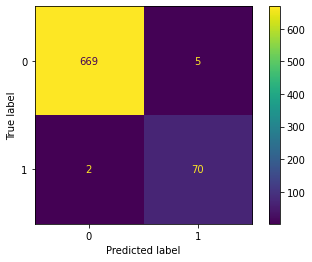

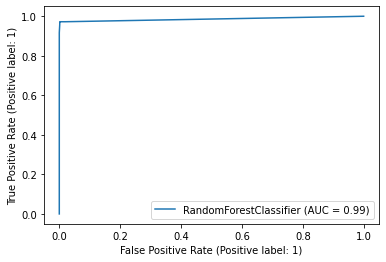

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 0.9986789960369881
The score for test data is 0.9959785522788204


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9936305732484076
the test recall for the class no is 0.9966044142614601
the training recall for the class yes is 0.9966555183946488
the training recall for the class no is 0.9991769547325103


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9873417721518988
the test precision for the class no is 0.9982993197278912
the training precision for the class yes is 0.9966555183946488
the training precision for the class no is 0.9991769547325103



              precision    recall  f1-score   support

         NO        1.00      1.00     

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


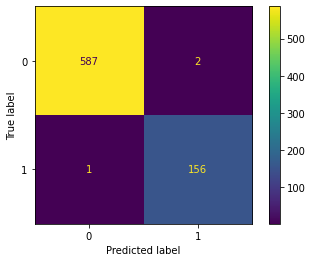

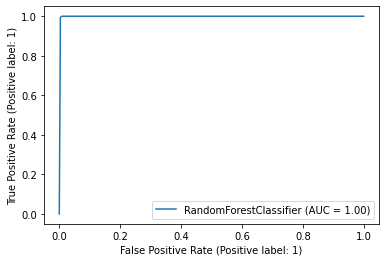

-------------------------------------------------------------------------------------------



abstract states: 93
Concrete states 270740
ratio 0.00034350299180025117
********************** reporting the result of the model **************************
The score for train data is 0.9993394980184941
The score for test data is 0.9986595174262735


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9861111111111112
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 0.9992810927390366


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9985185185185185
the training precision for the class yes is 0.9919354838709677
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00   

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


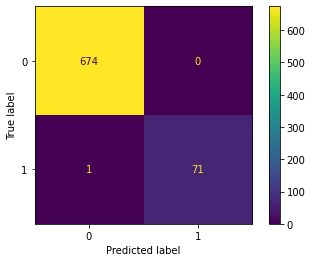

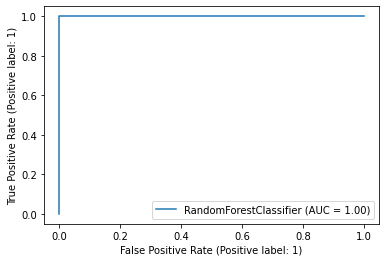

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9986595174262735


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 0.99830220713073
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9936708860759493
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       589
         yes       0.99      1.00      1.00       157

    accuracy                        

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


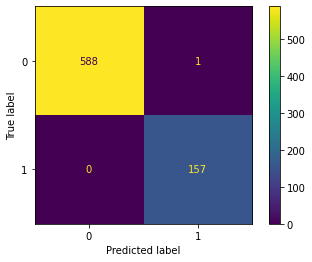

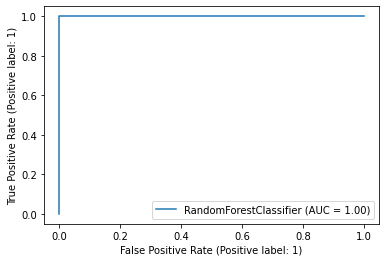

-------------------------------------------------------------------------------------------



abstract states: 890
Concrete states 270740
ratio 0.003287286695722834
********************** reporting the result of the model **************************
The score for train data is 0.9993394980184941
The score for test data is 0.9973190348525469


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9722222222222222
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 0.9992810927390366


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9970414201183432
the training precision for the class yes is 0.9919354838709677
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


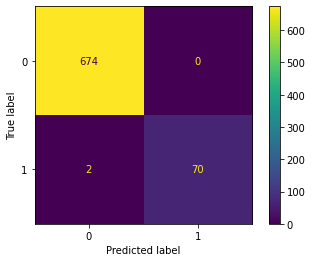

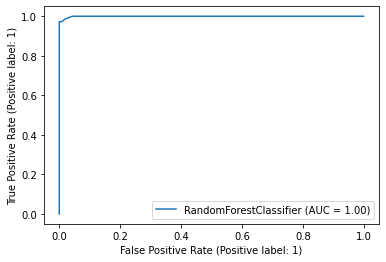

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9973190348525469


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 0.9966044142614601
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9874213836477987
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       589
         yes       0.99      1.00      0.99       157

    accuracy                      

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


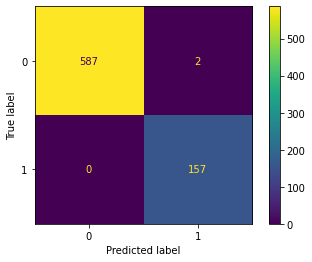

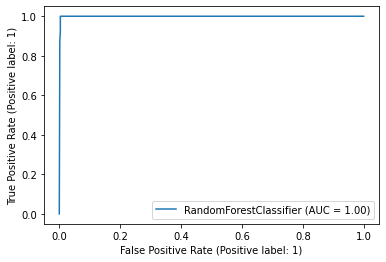

-------------------------------------------------------------------------------------------



abstract states: 2012
Concrete states 270740
ratio 0.007431484080667799
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9959785522788204


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9583333333333334
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9955686853766618
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       674
         yes     

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


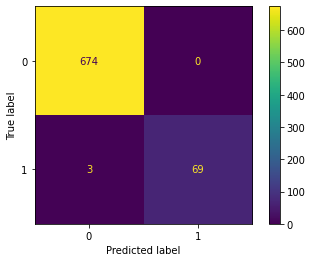

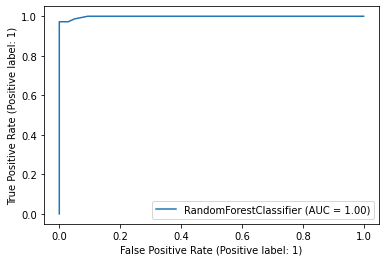

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9973190348525469


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 0.9966044142614601
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9874213836477987
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       589
         yes       0.99      1.00      0.99       157

    accuracy                      

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


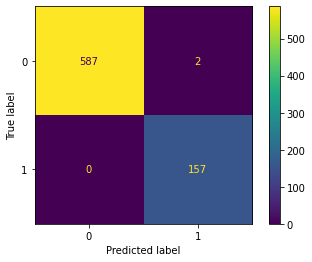

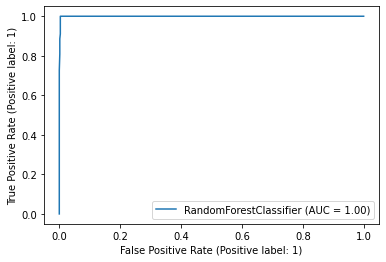

-------------------------------------------------------------------------------------------



abstract states: 10108
Concrete states 270740
ratio 0.03733471227007461
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9973190348525469


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9722222222222222
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9970414201183432
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       674
         yes     

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


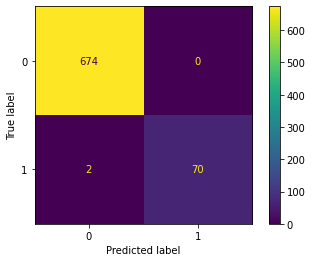

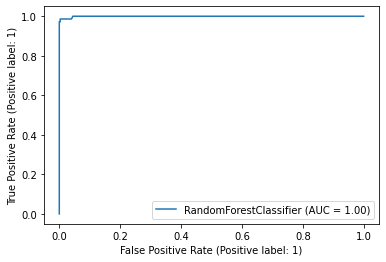

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9973190348525469


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 0.9966044142614601
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9874213836477987
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       589
         yes       0.99      1.00      0.99       157

    accuracy                      

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


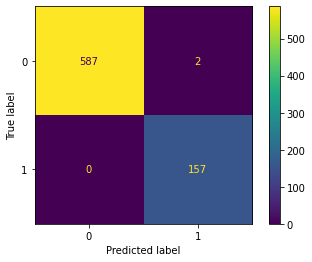

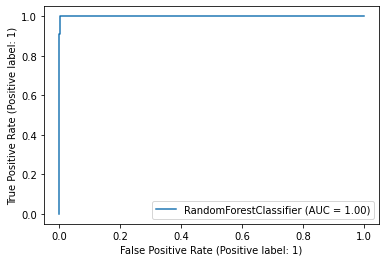

-------------------------------------------------------------------------------------------



abstract states: 19019
Concrete states 270740
ratio 0.07024820861342986
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9973190348525469


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9722222222222222
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9970414201183432
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       674
         yes     

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


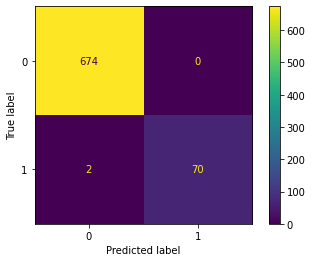

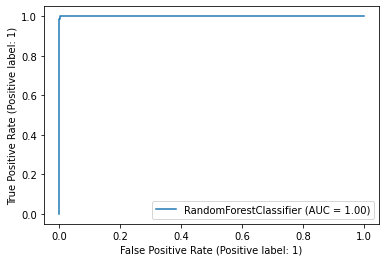

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9946380697050938


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9808917197452229
the test recall for the class no is 0.99830220713073
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9935483870967742
the test precision for the class no is 0.9949238578680203
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      1.00      1.00       589
         yes       0.99      0.98      0.99       157

    ac

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


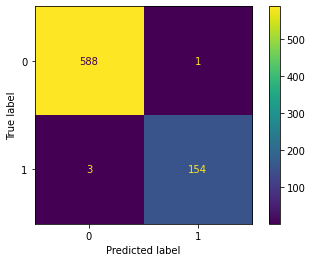

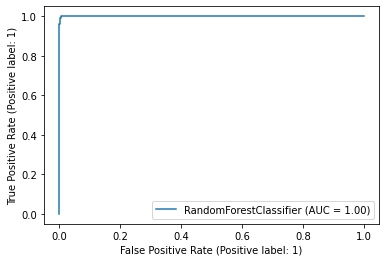

-------------------------------------------------------------------------------------------



abstract states: 59169
Concrete states 270740
ratio 0.21854546797665658
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9932975871313673


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9305555555555556
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9926362297496318
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      1.00      1.00       674
         yes     

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


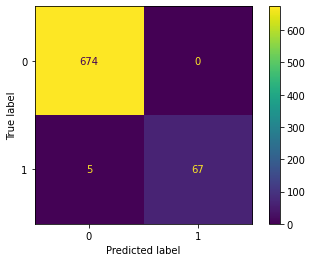

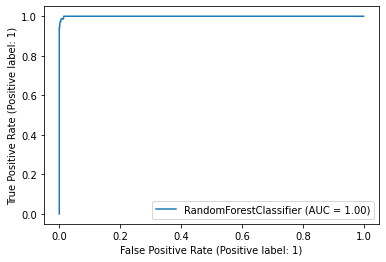

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9932975871313673


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9681528662420382
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9915824915824916
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      1.00      1.00       589
         yes       1.00      0.97      0.98       157

    accuracy                      

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


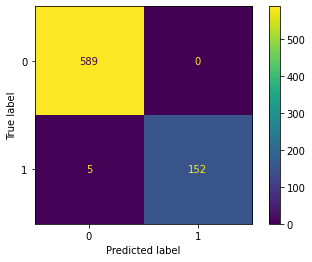

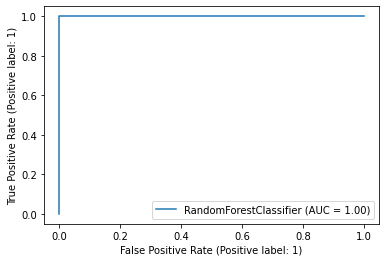

-------------------------------------------------------------------------------------------



abstract states: 83887
Concrete states 270740
ratio 0.30984339218438356
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9772117962466488


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.7638888888888888
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.975397973950796
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.98      1.00      0.99       674
         yes      

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


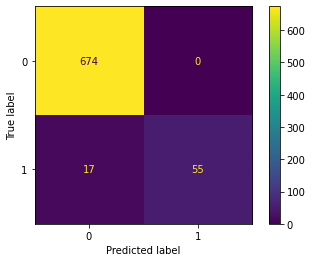

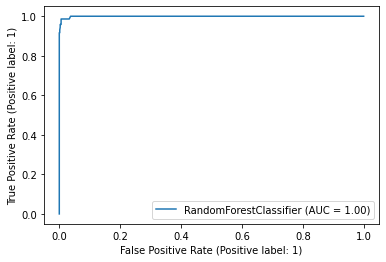

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9946380697050938


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9745222929936306
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9932546374367622
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      1.00      1.00       589
         yes       1.00      0.97      0.99       157

    accuracy                      

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


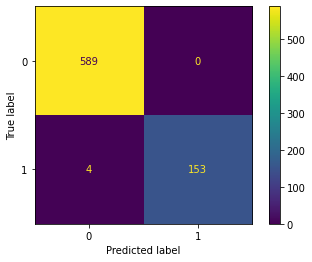

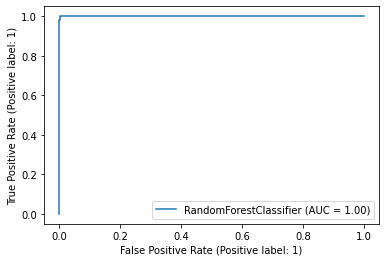

-------------------------------------------------------------------------------------------



abstract states: 160142
Concrete states 270740
ratio 0.5914973775578045


In [ ]:
#generate and save abstract classes
d_set=[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005]

report_functional = []
report_reward = []

for d in d_set:

  unique1,uni1 = Abstract_classes(final_episodes,d,model)
  with open(f'/content/drive/MyDrive/MC/Abstraction/Abstraction_data_sampled_200_{d}.pickle', 'wb') as file:
    pickle.dump(unique1, file)

  
  data1_x_b, data1_y_b, data1_y_f_b = ML_first_representation_func_based(d,is_functional_fault,is_reward_fault,model,final_episodes,unique1)



  X_train_reward_fault, X_test_reward_fault, y_train_reward_fault, y_test_reward_fault = train_test_split(data1_x_b, data1_y_b, test_size=0.33, random_state=42)
  RF_RF_1rep = RandomForestClassifier(random_state=0, class_weight='balanced')
  RF_RF_1rep.fit(X_train_reward_fault,y_train_reward_fault)
  report(RF_RF_1rep,X_train_reward_fault,y_train_reward_fault,X_test_reward_fault,y_test_reward_fault)
  report_reward.append(classification_report(y_test_reward_fault, RF_RF_1rep.predict(X_test_reward_fault), target_names=['NO ','yes'],output_dict=True))
  
  #########################################################   ML #############
  print("####################################################  functional fault ####################\n\n\n")

  X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(data1_x_b, data1_y_f_b, test_size=0.33, random_state=42)
  RF_FF_1rep = RandomForestClassifier(random_state=0, class_weight='balanced')
  RF_FF_1rep.fit(X_train_f,y_train_f)
  report(RF_FF_1rep,X_train_f,y_train_f,X_test_f,y_test_f)
  report_functional.append(classification_report(y_test_f, RF_FF_1rep.predict(X_test_f), target_names=['NO ','yes'],output_dict=True))

  print("-------------------------------------------------------------------------------------------\n\n\n")

with open(f'/content/drive/MyDrive/MT/Abstraction/report_rf.pickle', 'wb') as file:
    pickle.dump(report_reward, file)
with open(f'/content/drive/MyDrive/MT/Abstraction/report_ff.pickle', 'wb') as file:
    pickle.dump(report_functional, file)

In [ ]:
import os
d =1
os.path.exists(f'/content/drive/MyDrive/MC/Abstraction/Abstraction_data_sampled_200_{d}.pickle')

True

time: 24.7 ms (started: 2022-08-09 14:20:09 +00:00)


abstract states: 9
Concrete states 270740
ratio 3.324222501292753e-05
##########################################################################################



####################################################       d=10000      ####################



##########################################################################################



####################################################  Reward fault ####################



********************** reporting the result of the model **************************
The score for train data is 0.9860935524652339
The score for test data is 0.9882005899705014


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9692307692307692
the test recall for the class no is 0.9902120717781403
the training recall for the class yes is 0.9384615384615385
the training recall for the class no is 0.990358126721763


--------------------------------------precision--------------------

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


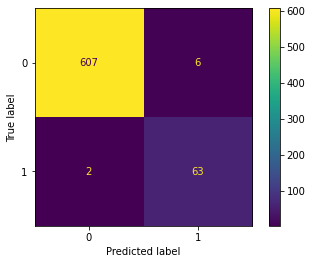

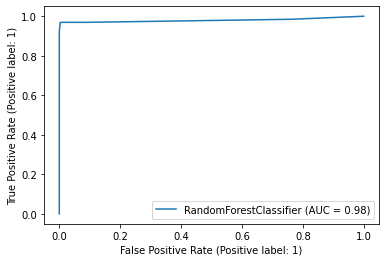

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 0.9405815423514539
The score for test data is 0.9321533923303835


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.697986577181208
the test recall for the class no is 0.998109640831758
the training recall for the class yes is 0.7198697068403909
the training recall for the class no is 0.9937254901960785


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9904761904761905
the test precision for the class no is 0.9214659685863874
the training precision for the class yes is 0.9650655021834061
the training precision for the class no is 0.9364375461936437



              precision    recall  f1-score   support

         NO        0.92      1.00      0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


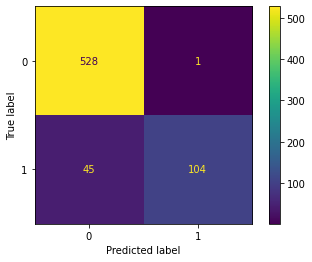

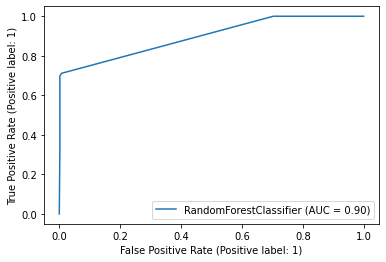

-------------------------------------------------------------------------------------------



abstract states: 10
Concrete states 270740
ratio 3.693580556991948e-05
##########################################################################################



####################################################       d=5000      ####################



##########################################################################################



####################################################  Reward fault ####################



********************** reporting the result of the model **************************
The score for train data is 0.9867256637168141
The score for test data is 0.9882005899705014


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9692307692307692
the test recall for the class no is 0.9902120717781403
the training recall for the class yes is 0.9461538461538461
the training recall for the clas

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


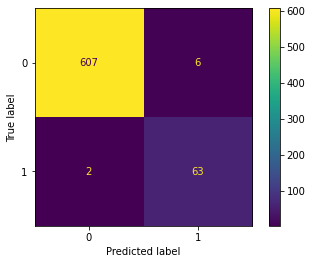

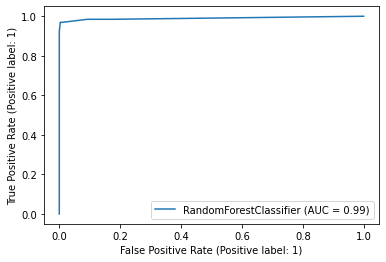

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 0.9778761061946902
The score for test data is 0.9823008849557522


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9865771812080537
the test recall for the class no is 0.9810964083175804
the training recall for the class yes is 0.996742671009772
the training recall for the class no is 0.9733333333333334


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9363057324840764
the test precision for the class no is 0.9961612284069098
the training precision for the class yes is 0.9
the training precision for the class no is 0.999194847020934



              precision    recall  f1-score   support

         NO        1.00      0.98      0.99       529
 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


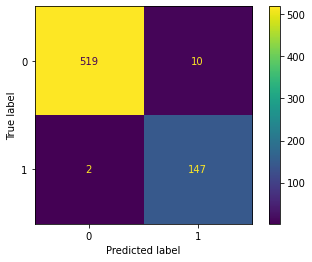

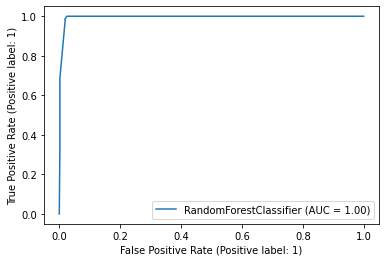

-------------------------------------------------------------------------------------------



##########################################################################################



####################################################       d=1000      ####################



##########################################################################################



####################################################  Reward fault ####################



********************** reporting the result of the model **************************
The score for train data is 0.9943109987357776
The score for test data is 0.9926253687315634


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9846153846153847
the test recall for the class no is 0.9934747145187602
the training recall for the class yes is 1.0
the training recall for the class no is 0.993801652892562


--------------------------------------precision-----------

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


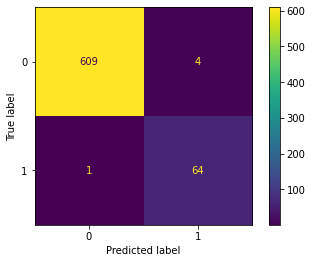

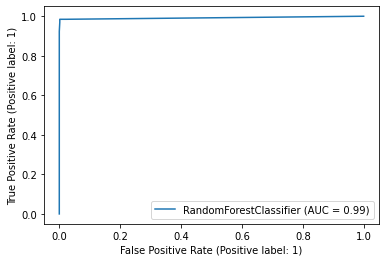

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 0.9981036662452591
The score for test data is 0.9970501474926253


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9932885906040269
the test recall for the class no is 0.998109640831758
the training recall for the class yes is 0.996742671009772
the training recall for the class no is 0.9984313725490196


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9932885906040269
the test precision for the class no is 0.998109640831758
the training precision for the class yes is 0.9935064935064936
the training precision for the class no is 0.9992150706436421



              precision    recall  f1-score   support

         NO        1.00      1.00      1.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


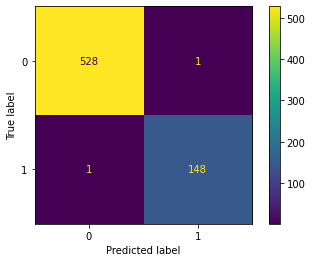

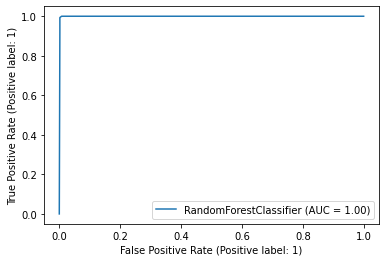

-------------------------------------------------------------------------------------------



##########################################################################################



####################################################       d=500      ####################



##########################################################################################



####################################################  Reward fault ####################



********************** reporting the result of the model **************************
The score for train data is 0.9993678887484198
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 0.9993112947658402


--------------------------------------precision------------------------------
the test precision for th

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


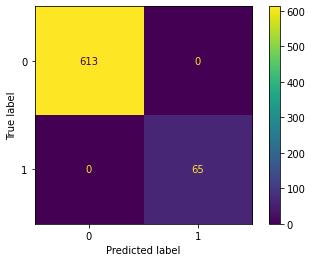

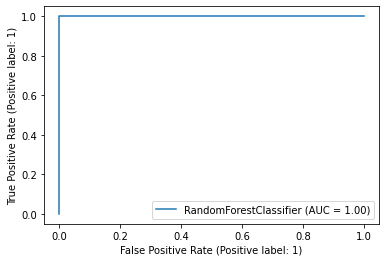

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       529
         yes       1.00      1.00      1.00       149

    accuracy                           1.00       678
   macro avg       1.00  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


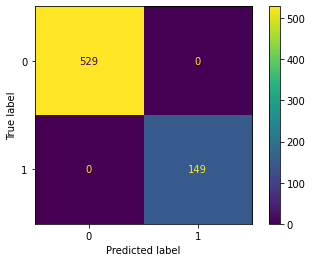

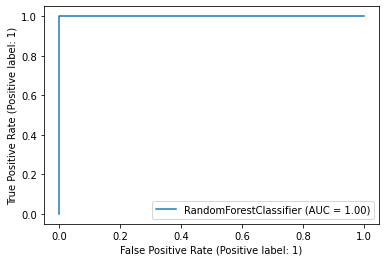

-------------------------------------------------------------------------------------------



##########################################################################################



####################################################       d=100      ####################



##########################################################################################



####################################################  Reward fault ####################



********************** reporting the result of the model **************************
The score for train data is 0.9993678887484198
The score for test data is 0.9985250737463127


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9846153846153847
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 0.9993112947658402


--------------------------------------precision--------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


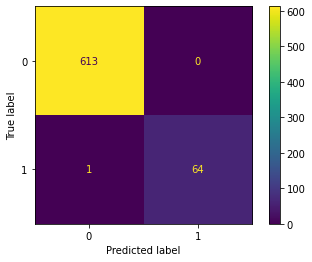

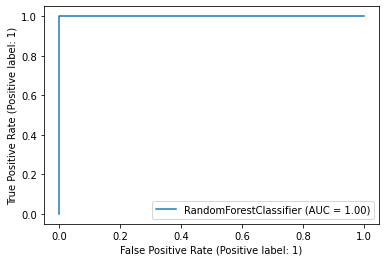

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9985250737463127


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 0.998109640831758
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9933333333333333
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       529
         yes       0.99      1.00      1.00       149

    accuracy                       

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


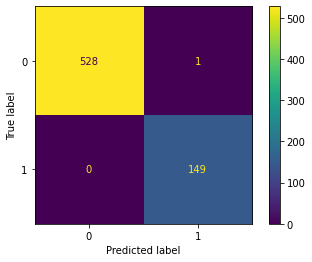

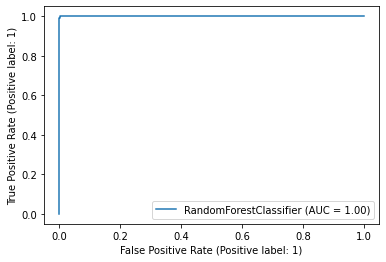

-------------------------------------------------------------------------------------------



##########################################################################################



####################################################       d=50      ####################



##########################################################################################



####################################################  Reward fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9970501474926253


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9692307692307692
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


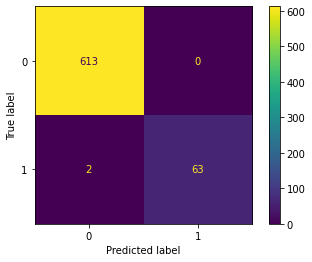

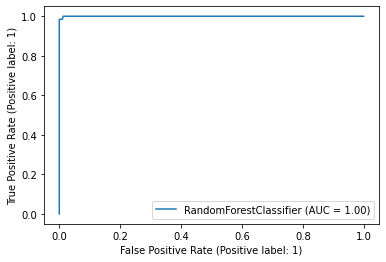

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9985250737463127


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 0.998109640831758
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9933333333333333
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       529
         yes       0.99      1.00      1.00       149

    accuracy                       

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


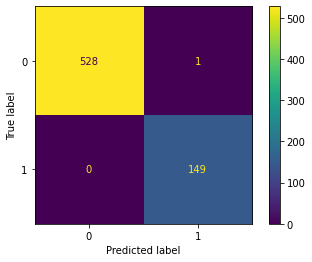

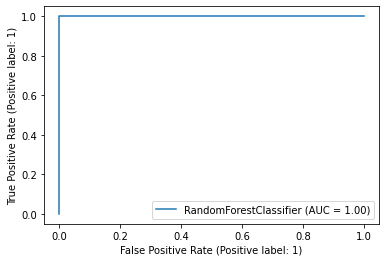

-------------------------------------------------------------------------------------------



##########################################################################################



####################################################       d=10      ####################



##########################################################################################



####################################################  Reward fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.995575221238938


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9538461538461539
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


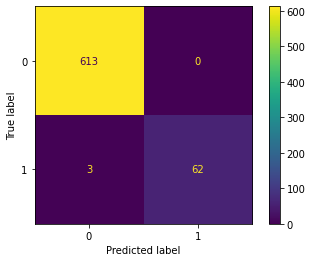

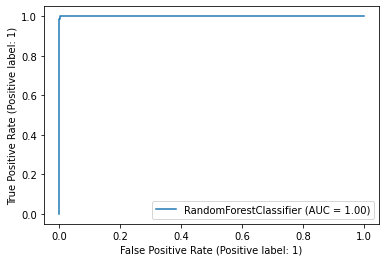

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9970501474926253


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9932885906040269
the test recall for the class no is 0.998109640831758
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9932885906040269
the test precision for the class no is 0.998109640831758
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       529
         yes       0.99      0.99      0.99       149

    ac

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


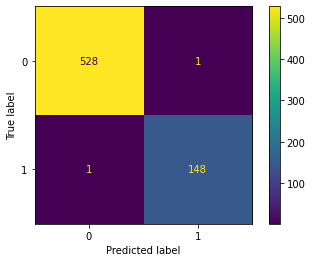

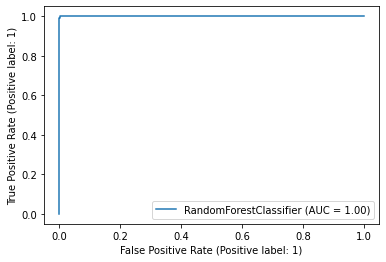

-------------------------------------------------------------------------------------------



##########################################################################################



####################################################       d=5      ####################



##########################################################################################



####################################################  Reward fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9985250737463127


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9846153846153847
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


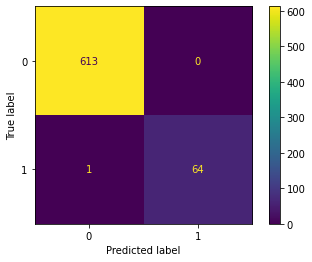

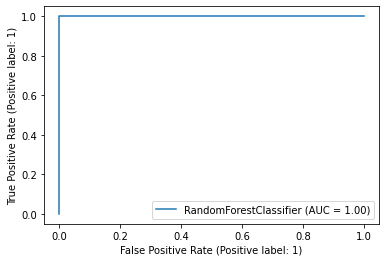

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.995575221238938


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9798657718120806
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9943609022556391
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      1.00      1.00       529
         yes       1.00      0.98      0.99       149

    accuracy                       

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


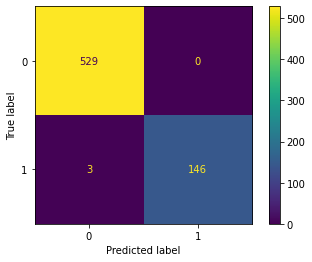

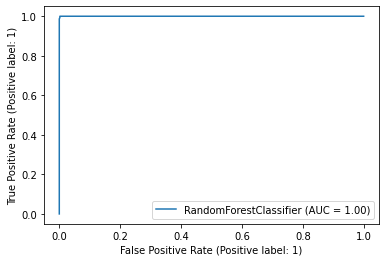

-------------------------------------------------------------------------------------------



##########################################################################################



####################################################       d=1      ####################



##########################################################################################



####################################################  Reward fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9926253687315634


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9230769230769231
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


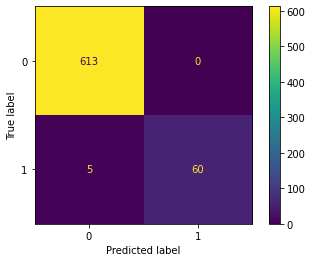

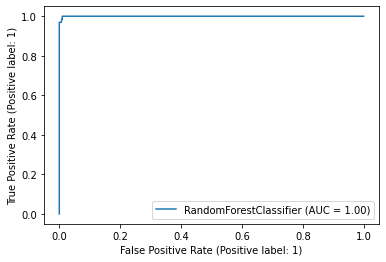

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9926253687315634


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9664429530201343
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9906367041198502
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      1.00      1.00       529
         yes       1.00      0.97      0.98       149

    accuracy                      

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


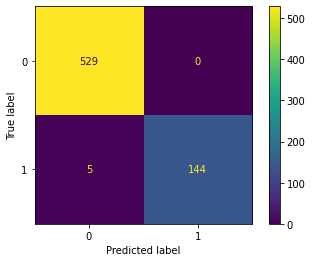

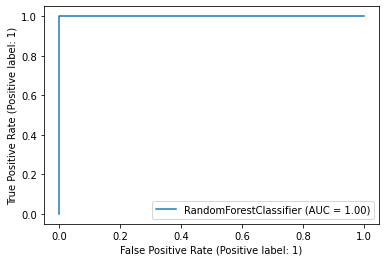

-------------------------------------------------------------------------------------------



##########################################################################################



####################################################       d=0.5      ####################



##########################################################################################



####################################################  Reward fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9808259587020649


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.8
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


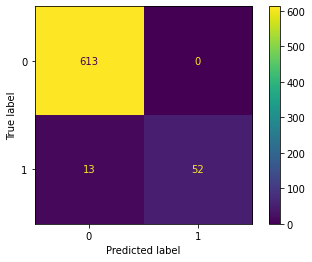

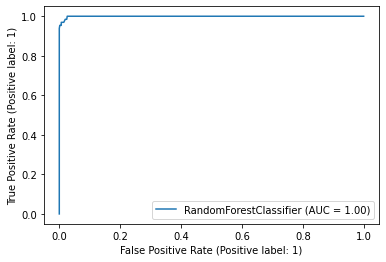

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.995575221238938


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9798657718120806
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9943609022556391
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      1.00      1.00       529
         yes       1.00      0.98      0.99       149

    accuracy                       

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


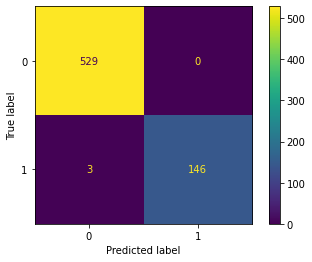

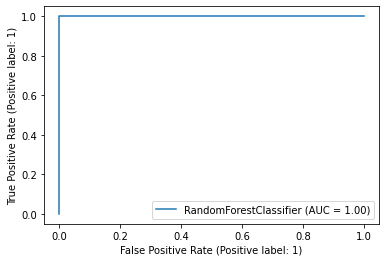

-------------------------------------------------------------------------------------------



##########################################################################################



####################################################       d=0.1      ####################



##########################################################################################



####################################################  Reward fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9129793510324484


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.09230769230769231
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for t

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


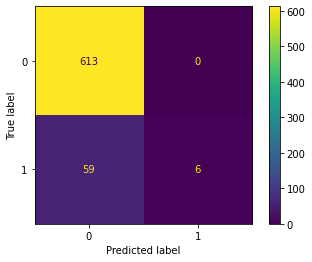

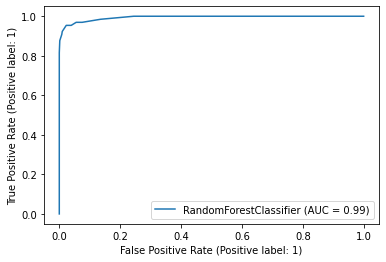

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.8805309734513275


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.4563758389261745
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.8672131147540983
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.87      1.00      0.93       529
         yes       1.00      0.46      0.63       149

    accuracy                      

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


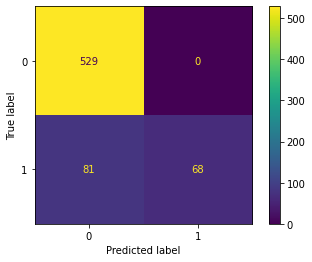

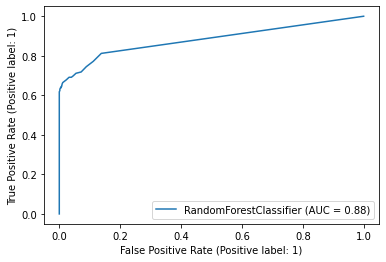

-------------------------------------------------------------------------------------------



abstract states: 195864
Concrete states 270740
ratio 0.7234394622146709
##########################################################################################



####################################################       d=0.05      ####################



##########################################################################################



####################################################  Reward fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9041297935103245


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precisi

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: Undefine

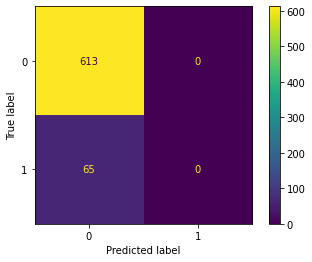

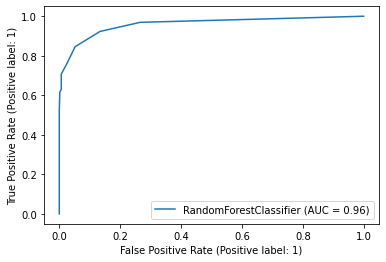

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.8407079646017699


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.2751677852348993
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.8304552590266876
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.83      1.00      0.91       529
         yes       1.00      0.28      0.43       149

    accuracy                      

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


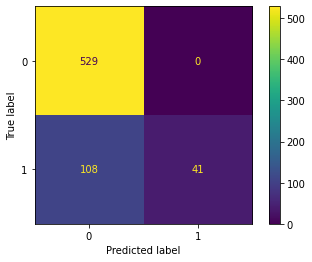

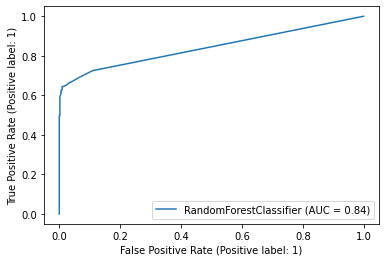

-------------------------------------------------------------------------------------------



abstract states: 246624
Concrete states 270740
ratio 0.9109256112875822
##########################################################################################



####################################################       d=0.01      ####################



##########################################################################################



####################################################  Reward fault ####################



********************** reporting the result of the model **************************
The score for train data is 0.9993678887484198
The score for test data is 0.9041297935103245


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.0
the test recall for the class no is 1.0
the training recall for the class yes is 0.9923076923076923
the training recall for the class no is 1.0


---------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: Undefine

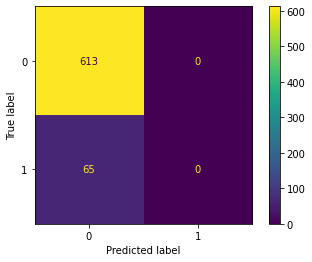

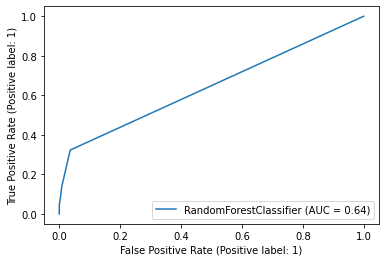

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 0.9993678887484198
The score for test data is 0.7876106194690266


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.03355704697986577
the test recall for the class no is 1.0
the training recall for the class yes is 0.996742671009772
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.7860326894502229
the training precision for the class yes is 1.0
the training precision for the class no is 0.9992163009404389



              precision    recall  f1-score   support

         NO        0.79      1.00      0.88       529
         yes       1.00      0.03      0.06 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


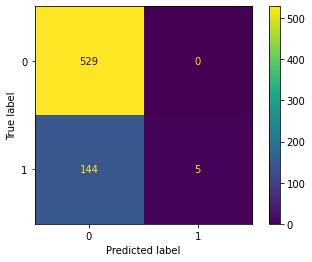

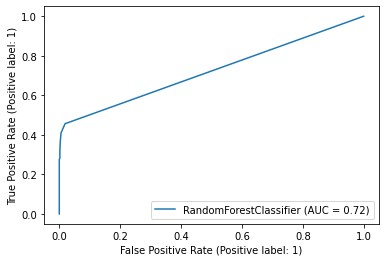

-------------------------------------------------------------------------------------------



abstract states: 256826
Concrete states 270740
ratio 0.948607520130014


In [ ]:
d_set=[10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005]
# d_set=[1]
report_functional = []
report_reward = []

for d in d_set:

  if os.path.exists(f'/content/drive/MyDrive/MC/Abstraction/Abstraction_data_sampled_200_{d}.pickle'):
    with open(f'/content/drive/MyDrive/MC/Abstraction/Abstraction_data_sampled_200_{d}.pickle', 'rb') as file2:
        unique1 = pickle.load(file2)
    uni1 = np.array(unique1)
  else:
    unique1,uni1 = Abstract_classes(final_episodes,d,model)
    with open(f'/content/drive/MyDrive/MC/Abstraction/Abstraction_data_sampled_200_{d}.pickle', 'wb') as file:
      pickle.dump(unique1, file)

  
  data1_x_b, data1_y_b, data1_y_f_b = ML_first_representation_func_based(d,is_functional_fault,is_reward_fault,model,final_episodes,unique1)
  print("##########################################################################################\n\n\n")
  print(f"####################################################       d={d}      ####################\n\n\n")
  print("##########################################################################################\n\n\n")

  print("####################################################  Reward fault ####################\n\n\n")

  X_train_reward_fault, X_test_reward_fault, y_train_reward_fault, y_test_reward_fault = train_test_split(data1_x_b, data1_y_b, test_size=0.30, random_state=42)
  RF_RF_1rep = RandomForestClassifier(random_state=0, class_weight='balanced')
  RF_RF_1rep.fit(X_train_reward_fault,y_train_reward_fault)
  report(RF_RF_1rep,X_train_reward_fault,y_train_reward_fault,X_test_reward_fault,y_test_reward_fault)
  report_reward.append(classification_report(y_test_reward_fault, RF_RF_1rep.predict(X_test_reward_fault), target_names=['NO ','yes'],output_dict=True))
  
  #########################################################   ML #############
  print("####################################################  functional fault ####################\n\n\n")

  X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(data1_x_b, data1_y_f_b, test_size=0.30, random_state=42)
  RF_FF_1rep = RandomForestClassifier(random_state=0, class_weight='balanced')
  RF_FF_1rep.fit(X_train_f,y_train_f)
  report(RF_FF_1rep,X_train_f,y_train_f,X_test_f,y_test_f)
  report_functional.append(classification_report(y_test_f, RF_FF_1rep.predict(X_test_f), target_names=['NO ','yes'],output_dict=True))

  print("-------------------------------------------------------------------------------------------\n\n\n")

with open(f'/content/drive/MyDrive/MC/Abstraction/report_rf.pickle', 'wb') as file:
    pickle.dump(report_reward, file)
with open(f'/content/drive/MyDrive/MC/Abstraction/report_ff.pickle', 'wb') as file:
    pickle.dump(report_functional, file)

Abstraction size: 9
##########################################################################################



####################################################       d=10000      ####################



##########################################################################################



####################################################  Reward fault ####################



********************** reporting the result of the model **************************
The score for train data is 0.9860935524652339
The score for test data is 0.9882005899705014


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9692307692307692
the test recall for the class no is 0.9902120717781403
the training recall for the class yes is 0.9384615384615385
the training recall for the class no is 0.990358126721763


--------------------------------------precision------------------------------
the test precision for the class yes is

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


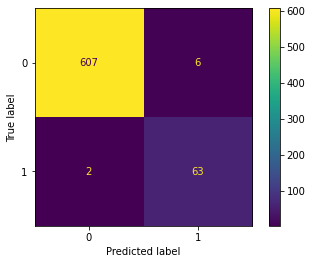

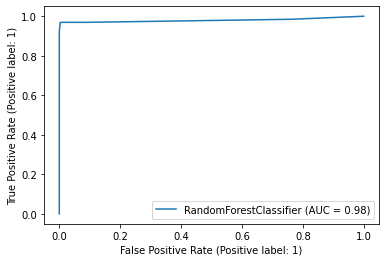

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 0.9405815423514539
The score for test data is 0.9321533923303835


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.697986577181208
the test recall for the class no is 0.998109640831758
the training recall for the class yes is 0.7198697068403909
the training recall for the class no is 0.9937254901960785


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9904761904761905
the test precision for the class no is 0.9214659685863874
the training precision for the class yes is 0.9650655021834061
the training precision for the class no is 0.9364375461936437



              precision    recall  f1-score   support

         NO        0.92      1.00      0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


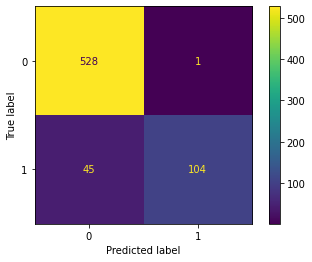

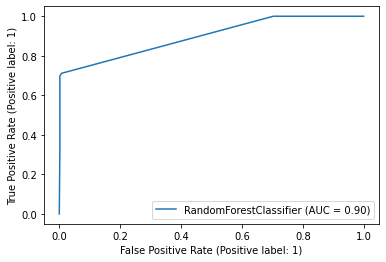

-------------------------------------------------------------------------------------------



Abstraction size: 10
##########################################################################################



####################################################       d=5000      ####################



##########################################################################################



####################################################  Reward fault ####################



********************** reporting the result of the model **************************
The score for train data is 0.9867256637168141
The score for test data is 0.9882005899705014


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9692307692307692
the test recall for the class no is 0.9902120717781403
the training recall for the class yes is 0.9461538461538461
the training recall for the class no is 0.990358126721763


----------------------

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


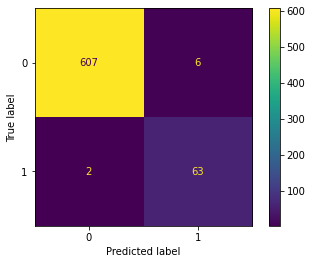

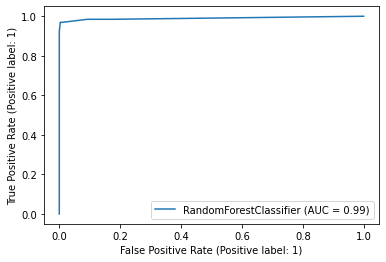

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 0.9778761061946902
The score for test data is 0.9823008849557522


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9865771812080537
the test recall for the class no is 0.9810964083175804
the training recall for the class yes is 0.996742671009772
the training recall for the class no is 0.9733333333333334


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9363057324840764
the test precision for the class no is 0.9961612284069098
the training precision for the class yes is 0.9
the training precision for the class no is 0.999194847020934



              precision    recall  f1-score   support

         NO        1.00      0.98      0.99       529
 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


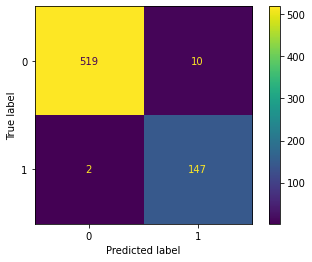

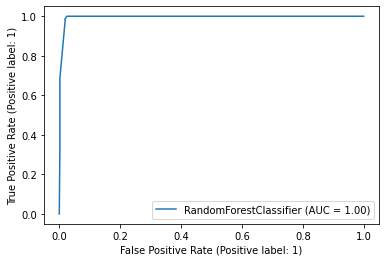

-------------------------------------------------------------------------------------------



Abstraction size: 38
##########################################################################################



####################################################       d=1000      ####################



##########################################################################################



####################################################  Reward fault ####################



********************** reporting the result of the model **************************
The score for train data is 0.9943109987357776
The score for test data is 0.9926253687315634


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9846153846153847
the test recall for the class no is 0.9934747145187602
the training recall for the class yes is 1.0
the training recall for the class no is 0.993801652892562


-------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


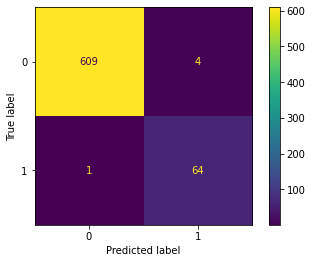

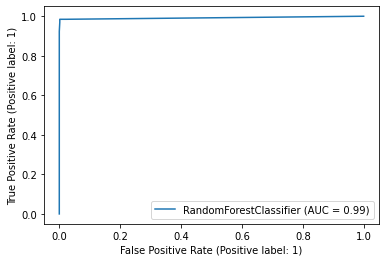

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 0.9981036662452591
The score for test data is 0.9970501474926253


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9932885906040269
the test recall for the class no is 0.998109640831758
the training recall for the class yes is 0.996742671009772
the training recall for the class no is 0.9984313725490196


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9932885906040269
the test precision for the class no is 0.998109640831758
the training precision for the class yes is 0.9935064935064936
the training precision for the class no is 0.9992150706436421



              precision    recall  f1-score   support

         NO        1.00      1.00      1.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


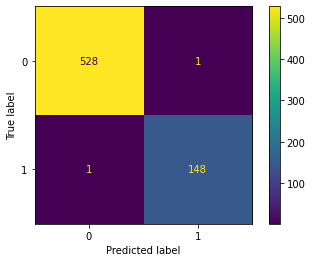

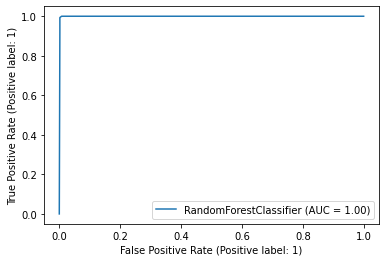

-------------------------------------------------------------------------------------------



Abstraction size: 93
##########################################################################################



####################################################       d=500      ####################



##########################################################################################



####################################################  Reward fault ####################



********************** reporting the result of the model **************************
The score for train data is 0.9993678887484198
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 0.9993112947658402


--------------------------------------precision------------------------------
the 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


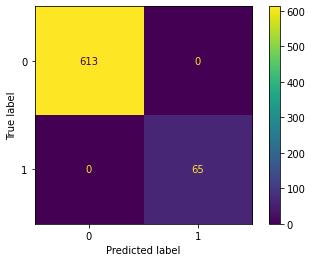

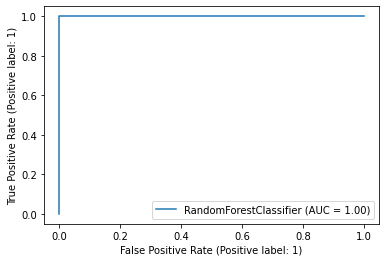

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       529
         yes       1.00      1.00      1.00       149

    accuracy                           1.00       678
   macro avg       1.00  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


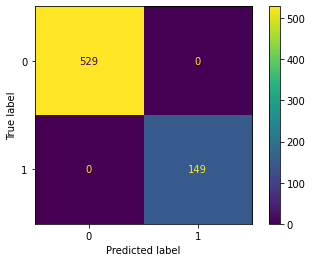

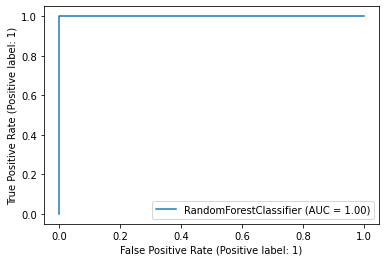

-------------------------------------------------------------------------------------------



Abstraction size: 890
##########################################################################################



####################################################       d=100      ####################



##########################################################################################



####################################################  Reward fault ####################



********************** reporting the result of the model **************************
The score for train data is 0.9993678887484198
The score for test data is 0.9985250737463127


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9846153846153847
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 0.9993112947658402


--------------------------------------precision----

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


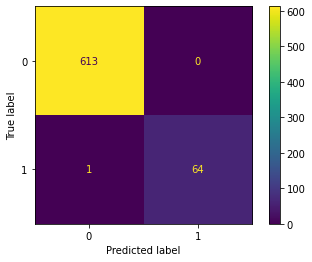

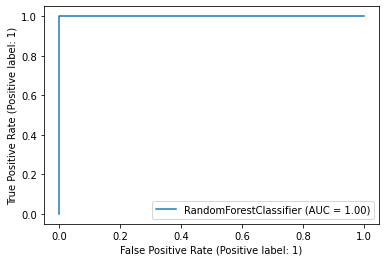

####################################################  functional fault ####################



********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9985250737463127


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 0.998109640831758
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9933333333333333
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       529
         yes       0.99      1.00      1.00       149

    accuracy                       

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


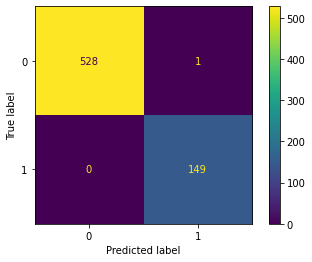

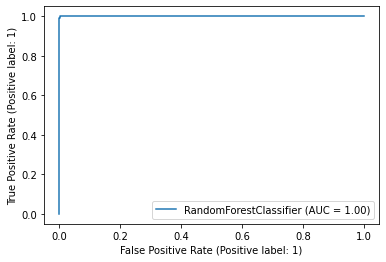

-------------------------------------------------------------------------------------------



Abstraction size: 2012


In [ ]:
d_set=[10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005]
# d_set=[1]
report_functional = []
report_reward = []

for d in d_set:

  if os.path.exists(f'/content/drive/MyDrive/MC/Abstraction/Abstraction_data_sampled_200_{d}.pickle'):
    with open(f'/content/drive/MyDrive/MC/Abstraction/Abstraction_data_sampled_200_{d}.pickle', 'rb') as file2:
        unique1 = pickle.load(file2)
    uni1 = np.array(unique1)
    print(f'Abstraction size: {len(uni1)}')
  else:
    unique1,uni1 = Abstract_classes(final_episodes,d,model)
    with open(f'/content/drive/MyDrive/MC/Abstraction/Abstraction_data_sampled_200_{d}.pickle', 'wb') as file:
      pickle.dump(unique1, file)

  
  data1_x_b, data1_y_b, data1_y_f_b = ML_first_representation_func_based(d,is_functional_fault,is_reward_fault,model,final_episodes,unique1)
  print("##########################################################################################\n\n\n")
  print(f"####################################################       d={d}      ####################\n\n\n")
  print("##########################################################################################\n\n\n")

  print("####################################################  Reward fault ####################\n\n\n")

  X_train_reward_fault, X_test_reward_fault, y_train_reward_fault, y_test_reward_fault = train_test_split(data1_x_b, data1_y_b, test_size=0.30, random_state=42)
  RF_RF_1rep = RandomForestClassifier(random_state=0, class_weight='balanced')
  RF_RF_1rep.fit(X_train_reward_fault,y_train_reward_fault)
  report(RF_RF_1rep,X_train_reward_fault,y_train_reward_fault,X_test_reward_fault,y_test_reward_fault)
  report_reward.append(classification_report(y_test_reward_fault, RF_RF_1rep.predict(X_test_reward_fault), target_names=['NO ','yes'],output_dict=True))
  
  #########################################################   ML #############
  print("####################################################  functional fault ####################\n\n\n")

  X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(data1_x_b, data1_y_f_b, test_size=0.30, random_state=42)
  RF_FF_1rep = RandomForestClassifier(random_state=0, class_weight='balanced')
  RF_FF_1rep.fit(X_train_f,y_train_f)
  report(RF_FF_1rep,X_train_f,y_train_f,X_test_f,y_test_f)
  report_functional.append(classification_report(y_test_f, RF_FF_1rep.predict(X_test_f), target_names=['NO ','yes'],output_dict=True))

  print("-------------------------------------------------------------------------------------------\n\n\n")

with open(f'/content/drive/MyDrive/MC/Abstraction/report_rf.pickle', 'wb') as file:
    pickle.dump(report_reward, file)
with open(f'/content/drive/MyDrive/MC/Abstraction/report_ff.pickle', 'wb') as file:
    pickle.dump(report_functional, file)

# Execution 







Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







Loading a model without an environment, this model cannot be trained until it has a valid environment.
********************** reporting the result of the model **************************
The score for train data is 0.9993394980184941
The score for test data is 0.9986595174262735


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9861111111111112
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 0.9992810927390366


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9985185185185185
the training preci

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


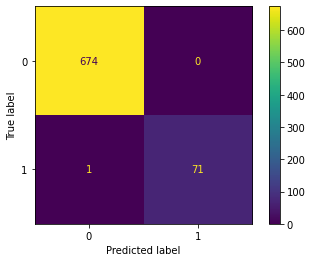

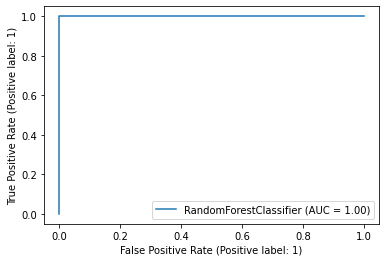

********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9986595174262735


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 0.99830220713073
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9936708860759493
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       589
         yes       0.99      1.00      1.00       157

    accuracy                           1.00       746
   macro avg       1.00      1.00      1.00       746
weighted avg       1.00

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


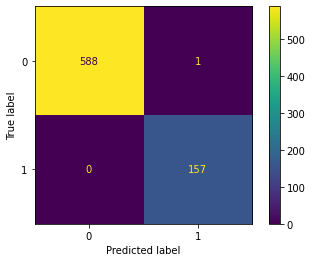

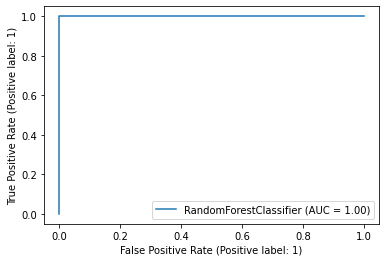

In [23]:
#Address of the trained RL model 
Drive_model  ="c:/Users/Student/Desktop/Data/dqn-4-1-6-89946.zip"

mtc = gym.make('MountainCar-v0')
mtc_wrapped = StoreAndTerminateWrapper(mtc)
model = DQN('MlpPolicy',env=mtc_wrapped, verbose=1)
model = model.load(Drive_model)

#########################################################  Read DATA and Load Model #############


final_episodes = local_load_p("Final_episodes_trainand_Test_2062_FIXED2.pickle")

######################################################### Read abstract classes #############
# data of abstract classes

Read_from_data = True
d=500

if Read_from_data:
  with open(f'c:/Users/Student/Desktop/Data/Abstraction/Abstraction_data_sampled_200_{d}.pickle', 'rb') as file2:
      unique1 = pickle.load(file2)
  uni1=np.array(unique1)
  unique5 = unique1
if not Read_from_data:
  unique1,uni1 = Abstract_classes(final_episodes,d,model)
  unique5 = unique1


epsilon = 0.1
data1_x_b, data1_y_b, data1_y_f_b = ML_first_representation_func_based(d,
                                                                       is_functional_fault,
                                                                       is_reward_fault
                                                                       ,model
                                                                       ,final_episodes
                                                                       ,unique1)

#########################################################  Train ML -  Reward fault predictor  #############

X_train_reward_fault, X_test_reward_fault, y_train_reward_fault, y_test_reward_fault = train_test_split(data1_x_b, data1_y_b, test_size=0.33, random_state=42)

RF_RF_1rep = RandomForestClassifier(random_state=0, class_weight='balanced')
RF_RF_1rep.fit(X_train_reward_fault,y_train_reward_fault)
report(RF_RF_1rep,X_train_reward_fault,y_train_reward_fault,X_test_reward_fault,y_test_reward_fault)

#########################################################  Train ML - Functional fault predictor #############


X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(data1_x_b, data1_y_f_b, test_size=0.33, random_state=42)
RF_FF_1rep = RandomForestClassifier(random_state=0, class_weight='balanced')
RF_FF_1rep.fit(X_train_f,y_train_f)
report(RF_FF_1rep,X_train_f,y_train_f,X_test_f,y_test_f)





# objectives

In [ ]:
ee,qq=random_test_2(model,mtc_wrapped,400_000)  #create initial population with random test, in case if the environment is complex and this is time consuming you can use the episodes created for ml part 
test, teststate = fix_testing(ee,qq,mtc_wrapped)
print('len population',len(test))
start_state_ep1 = teststate
ep1=test
Sample_population = []
for i in range(0,1000):  #size of the initial population is 1500
    cd = Candidate(ep1[i])
    cd.set_start_state(start_state_ep1[i])
    Sample_population.append(cd)

In [ ]:
f1,f2,f3 = get_3objective_distribution_and_set_candidate_objectives(Sample_population,model,d,unique1,RF_FF_1rep)

time: 3min 38s (started: 2022-08-22 18:55:50 +00:00)


(array([191.,   0.,   0.,   0.,   0.,   0.,  88., 153.,  76., 992.]),
 array([-200. , -190.6, -181.2, -171.8, -162.4, -153. , -143.6, -134.2,
        -124.8, -115.4, -106. ]),
 <a list of 10 Patch objects>)

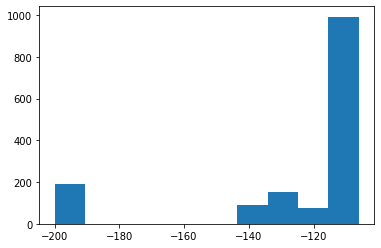

time: 190 ms (started: 2022-08-22 19:44:37 +00:00)


In [ ]:
plt.hist(f1)

(array([ 37., 103., 224., 231., 146., 124., 197., 101., 251.,  86.]),
 array([0.78442166, 0.79290836, 0.80139506, 0.80988175, 0.81836845,
        0.82685515, 0.83534184, 0.84382854, 0.85231524, 0.86080193,
        0.86928863]),
 <a list of 10 Patch objects>)

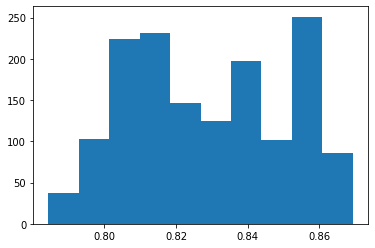

time: 212 ms (started: 2022-08-22 19:44:41 +00:00)


In [ ]:
plt.hist(f2)

(array([ 191.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1309.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

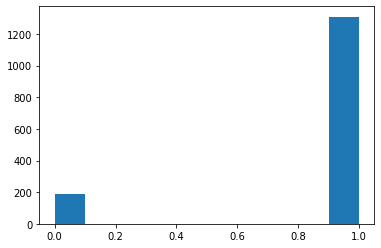

time: 208 ms (started: 2022-08-22 19:44:48 +00:00)


In [ ]:
plt.hist(f3)

# Run

In [24]:
MUTATION_NUMBER=0 #set the mutation counter to 0
#  from 7 i removed crossover logging 
Run_number = 1
for s in range(10):
  ee,qq=random_test_2(model,mtc_wrapped,400_000)  #create initial population with random test, in case of complex environments you can use the episodes created for ml part 
  test, teststate = fix_testing(ee,qq,mtc_wrapped)
  print('len population',len(test))
  start_state_ep1 = teststate
  ep1=test
  population = []
  for i in range(0,1500):  #size of the initial population is 1500
    cd = Candidate(ep1[i])
    cd.set_start_state(start_state_ep1[i])
    population.append(cd)
  archive1 = []
  second_arch1 =[]
  generations=[] # all of the episodes generated during the search
  run(0,population,archive1,second_arch1,generations)

  with open(f'c:/Users/Student/Desktop/Data/NewResults1207/Results/Dec07_arch1_population1000lastfull_run{Run_number}_{s}.pickle', 'wb') as file:
    pickle.dump(archive1, file)
  with open(f'c:/Users/Student/Desktop/Data/NewResults1207/Results/Dec07_second_arch1_population1000lastfull_run{Run_number}_{s}.pickle', 'wb') as file:
    pickle.dump(second_arch1, file)
  with open(f'c:/Users/Student/Desktop/Data/NewResults1207/Results/Dec07_generations_population1000lastfull_run{Run_number}_{s}.pickle', 'wb') as file:
    pickle.dump(generations, file)
  mutation_number_update(f'c:/Users/Student/Desktop/Data/NewResults1207/Dec07Mutation_number_run{Run_number}.pickle',MUTATION_NUMBER,s)

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:550: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


len population 3551
initial population  <class 'list'> 1500
[-114.0, 0.8044900601370293, 1.0]
[-134.0, 0.8330910154687825, 1.0]
[-137.0, 0.8478679922375366, 1.0]
[-114.0, 0.7985246325271171, 1.0]
[-108.0, 0.8405331569137396, 1.0]
[-112.0, 0.8108600010829312, 1.0]
[-108.0, 0.8358117275767856, 1.0]
[-109.0, 0.8171442782660143, 1.0]
[-107.0, 0.8425368647152018, 1.0]
[-137.0, 0.8441307777470916, 1.0]
[-200, 0.7966668836234772, 0.0]
[-106.0, 0.8596322232822202, 1.0]
[-109.0, 0.8168775920474202, 1.0]
[-108.0, 0.8251518209775289, 1.0]
[-110.0, 0.812883963639086, 1.0]
[-200, 0.7879198603332043, 0.0]
[-122.0, 0.809352915062279, 1.0]
[-108.0, 0.840529334489946, 1.0]
[-135.0, 0.8344957927862803, 1.0]
[-200, 0.8634979631751776, 0.0]
[-110.0, 0.8162307208234614, 1.0]
[-133.0, 0.8113137053367787, 1.0]
[-200, 0.8635898583258191, 0.0]
[-108.0, 0.8395859309368663, 1.0]
[-106.0, 0.8572542178180983, 1.0]
[-110.0, 0.8128889289769259, 1.0]
[-109.0, 0.8180888992383939, 1.0]
[-132.0, 0.8022779960072401, 1.0]

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:550: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


len population 3556
initial population  <class 'list'> 1500
[-133.0, 0.8088207937272868, 1.0]
[-107.0, 0.8459698273756794, 1.0]
[-106.0, 0.8568545020413849, 1.0]
[-114.0, 0.805021752913793, 1.0]
[-135.0, 0.8334793344691948, 0.99]
[-122.0, 0.795952639618858, 1.0]
[-114.0, 0.8000733465479132, 1.0]
[-137.0, 0.8456205671286061, 1.0]
[-114.0, 0.8061182362991467, 1.0]
[-137.0, 0.8469782650035663, 1.0]
[-109.0, 0.8204644661430919, 1.0]
[-107.0, 0.8470627927334509, 1.0]
[-107.0, 0.8385786043706341, 1.0]
[-109.0, 0.822479503143818, 1.0]
[-110.0, 0.8127404684370214, 1.0]
[-107.0, 0.8464769342235315, 1.0]
[-108.0, 0.8363736092492386, 1.0]
[-106.0, 0.8573726485922651, 1.0]
[-122.0, 0.7967326325959847, 1.0]
[-109.0, 0.8230877584273663, 1.0]
[-107.0, 0.8476284452687914, 1.0]
[-200, 0.8690363218386968, 0.0]
[-200, 0.859167292714119, 0.0]
[-114.0, 0.797664820363647, 1.0]
[-106.0, 0.8570690152217757, 1.0]
[-107.0, 0.8498888191218689, 1.0]
[-200, 0.8400967316702008, 0.0]
[-107.0, 0.8478515039537554, 1.0

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:550: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


len population 3555
initial population  <class 'list'> 1500
[-108.0, 0.8223043409762559, 1.0]
[-122.0, 0.8046524370791482, 1.0]
[-122.0, 0.8046565195087527, 1.0]
[-112.0, 0.811882098870618, 1.0]
[-108.0, 0.8243099382078206, 1.0]
[-110.0, 0.812830365787853, 1.0]
[-133.0, 0.824642545970759, 1.0]
[-106.0, 0.8570422853501338, 1.0]
[-106.0, 0.8619898239958961, 1.0]
[-108.0, 0.8350397972045122, 1.0]
[-107.0, 0.8418344660340068, 1.0]
[-122.0, 0.8004587585808801, 1.0]
[-112.0, 0.8106331686888423, 1.0]
[-107.0, 0.8451326600859098, 1.0]
[-137.0, 0.8468328307579903, 1.0]
[-200, 0.8672527453551689, 0.0]
[-112.0, 0.8111571411469153, 1.0]
[-110.0, 0.8121873877265237, 1.0]
[-122.0, 0.809370619596028, 1.0]
[-108.0, 0.8220188512846276, 1.0]
[-110.0, 0.8159189105033875, 1.0]
[-134.0, 0.8291196923202543, 1.0]
[-137.0, 0.8391463654319735, 1.0]
[-200, 0.7958629945504296, 0.0]
[-133.0, 0.8136873888342004, 1.0]
[-108.0, 0.8341422224486316, 1.0]
[-133.0, 0.8230932845657033, 1.0]
[-110.0, 0.8144480962644923, 1

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:550: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


len population 3554
initial population  <class 'list'> 1500
[-114.0, 0.8056015654614097, 1.0]
[-112.0, 0.8096476420760155, 1.0]
[-133.0, 0.8254373588956389, 1.0]
[-113.0, 0.8077686843091407, 1.0]
[-135.0, 0.8343071674859083, 1.0]
[-108.0, 0.8219706421649015, 1.0]
[-109.0, 0.8154650497327157, 1.0]
[-106.0, 0.8590411338603722, 1.0]
[-108.0, 0.8320919192499585, 1.0]
[-200, 0.867925830806295, 0.0]
[-133.0, 0.8165167433426792, 1.0]
[-113.0, 0.804873907724313, 1.0]
[-106.0, 0.8574763809172612, 1.0]
[-200, 0.8608724415923158, 0.0]
[-112.0, 0.8089244086295366, 1.0]
[-106.0, 0.8598036268409693, 1.0]
[-106.0, 0.8573402160743497, 1.0]
[-108.0, 0.8405445513349993, 1.0]
[-200, 0.7863884971787533, 0.0]
[-108.0, 0.840537945429484, 1.0]
[-110.0, 0.8125601679086685, 1.0]
[-136.0, 0.8306456089896315, 1.0]
[-200, 0.8692048530404767, 0.0]
[-110.0, 0.812355190244588, 1.0]
[-112.0, 0.8118762049291816, 1.0]
[-108.0, 0.8397365424920011, 1.0]
[-110.0, 0.8143311568281867, 1.0]
[-137.0, 0.8393263834236312, 1.0]


c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:550: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


len population 3547
initial population  <class 'list'> 1500
[-200, 0.8692742865532637, 0.0]
[-134.0, 0.8293410555195453, 1.0]
[-108.0, 0.822056694439164, 1.0]
[-200, 0.8691186551004648, 0.0]
[-108.0, 0.8242663360304303, 1.0]
[-109.0, 0.815642520375208, 1.0]
[-106.0, 0.857068547381545, 1.0]
[-114.0, 0.8006976385388458, 1.0]
[-200, 0.7952062017524365, 0.0]
[-132.0, 0.8007402192011024, 1.0]
[-114.0, 0.8035004131103817, 1.0]
[-109.0, 0.817326009273529, 1.0]
[-200, 0.789293870019416, 0.0]
[-107.0, 0.8553121468731176, 1.0]
[-107.0, 0.8398374224377569, 1.0]
[-110.0, 0.813494164835323, 1.0]
[-108.0, 0.823102769476396, 1.0]
[-112.0, 0.8120334172355277, 1.0]
[-108.0, 0.8249286490458029, 1.0]
[-107.0, 0.857580543957024, 1.0]
[-122.0, 0.7977266658524997, 1.0]
[-106.0, 0.8602516209741808, 1.0]
[-106.0, 0.8573243308742091, 1.0]
[-110.0, 0.8110140524127266, 1.0]
[-135.0, 0.833728054717735, 1.0]
[-106.0, 0.8572234615402402, 1.0]
[-113.0, 0.8070402227144325, 1.0]
[-107.0, 0.8418614156892367, 1.0]
[-133

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:550: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


len population 3547
initial population  <class 'list'> 1500
[-106.0, 0.8571135716618232, 1.0]
[-137.0, 0.845837947443454, 1.0]
[-108.0, 0.8380684855359571, 1.0]
[-137.0, 0.837296317311099, 1.0]
[-110.0, 0.8128628546541388, 1.0]
[-132.0, 0.8077730854803865, 1.0]
[-110.0, 0.8115836376493627, 1.0]
[-107.0, 0.8558875302845073, 1.0]
[-108.0, 0.8305752158716873, 1.0]
[-110.0, 0.8164663092656569, 1.0]
[-106.0, 0.8605849180581435, 1.0]
[-106.0, 0.8579073376813025, 1.0]
[-110.0, 0.8098219741474498, 1.0]
[-134.0, 0.832749027814438, 1.0]
[-132.0, 0.8058088139602633, 1.0]
[-114.0, 0.8074200861809546, 1.0]
[-133.0, 0.8159459540270325, 1.0]
[-113.0, 0.8064433892743778, 1.0]
[-200, 0.8679092076296607, 0.0]
[-106.0, 0.8561918457161706, 1.0]
[-122.0, 0.8009302217940815, 1.0]
[-106.0, 0.8573013428809508, 1.0]
[-109.0, 0.8202465674199095, 1.0]
[-106.0, 0.8573115043482691, 1.0]
[-136.0, 0.8307053597972673, 1.0]
[-107.0, 0.8572899571088987, 1.0]
[-110.0, 0.8099039386619221, 1.0]
[-107.0, 0.848819798676767,

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:550: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


len population 3546
initial population  <class 'list'> 1500
[-137.0, 0.8444413899505225, 1.0]
[-107.0, 0.8507344616907779, 1.0]
[-137.0, 0.8489395778109557, 1.0]
[-109.0, 0.8191278418269726, 1.0]
[-107.0, 0.8566865063159266, 1.0]
[-106.0, 0.8569893207190171, 1.0]
[-106.0, 0.8623290821066443, 1.0]
[-200, 0.8464240416263541, 0.0]
[-200, 0.7966668031264826, 0.0]
[-137.0, 0.8417673709183714, 1.0]
[-107.0, 0.8453125892398513, 1.0]
[-108.0, 0.8361151759271268, 1.0]
[-106.0, 0.8617104159773521, 1.0]
[-108.0, 0.8385584001187925, 1.0]
[-106.0, 0.8562127447353219, 1.0]
[-122.0, 0.796945577029322, 1.0]
[-108.0, 0.8386031640348611, 1.0]
[-112.0, 0.8100033101758787, 1.0]
[-106.0, 0.860084481959073, 1.0]
[-114.0, 0.8000241622590182, 1.0]
[-133.0, 0.8241620944406753, 1.0]
[-107.0, 0.8571299715576884, 1.0]
[-108.0, 0.8323333608331503, 1.0]
[-108.0, 0.8348611228995853, 1.0]
[-133.0, 0.8227040366570753, 1.0]
[-112.0, 0.8102838088359151, 1.0]
[-106.0, 0.8603371019071003, 1.0]
[-107.0, 0.8399993125523362,

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:550: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


len population 3556
initial population  <class 'list'> 1500
[-132.0, 0.8073422567862453, 1.0]
[-106.0, 0.8585186890273724, 1.0]
[-110.0, 0.8163901599970731, 1.0]
[-109.0, 0.821117650478258, 1.0]
[-110.0, 0.8145850078626112, 1.0]
[-108.0, 0.8226722200159673, 1.0]
[-135.0, 0.8335504465632968, 0.99]
[-108.0, 0.821889759765731, 1.0]
[-109.0, 0.8210534633846458, 1.0]
[-110.0, 0.81289037195119, 1.0]
[-108.0, 0.8356401266323196, 1.0]
[-108.0, 0.8378915038925631, 1.0]
[-114.0, 0.7991075829455727, 1.0]
[-106.0, 0.8572644487304507, 1.0]
[-132.0, 0.8097487545826219, 1.0]
[-107.0, 0.8515041946807754, 1.0]
[-106.0, 0.8595482175642589, 1.0]
[-108.0, 0.8299403303751239, 1.0]
[-110.0, 0.8121457422321493, 1.0]
[-107.0, 0.8568282575807838, 1.0]
[-132.0, 0.8085777260588877, 1.0]
[-200, 0.7939693577510795, 0.0]
[-106.0, 0.8594676101545118, 1.0]
[-122.0, 0.8016191393625541, 1.0]
[-106.0, 0.8610786708458414, 1.0]
[-110.0, 0.8134561687707901, 1.0]
[-200, 0.7964484064849382, 0.0]
[-122.0, 0.8085507310804774, 

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:550: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


len population 3559
initial population  <class 'list'> 1500
[-107.0, 0.8533331425947563, 1.0]
[-108.0, 0.8317339605203381, 1.0]
[-137.0, 0.8377178463622601, 1.0]
[-106.0, 0.8623039964235054, 1.0]
[-106.0, 0.8598019081466602, 1.0]
[-122.0, 0.7990069765536512, 1.0]
[-122.0, 0.7950017686750068, 1.0]
[-113.0, 0.810049695778737, 1.0]
[-114.0, 0.8079703894623539, 1.0]
[-200, 0.84260878401498, 0.0]
[-109.0, 0.8187860091891858, 1.0]
[-106.0, 0.8566535030895809, 1.0]
[-114.0, 0.8018060423303068, 1.0]
[-112.0, 0.8103772811591625, 1.0]
[-110.0, 0.8122272496873683, 1.0]
[-108.0, 0.8303354619829743, 1.0]
[-200, 0.8687260405470928, 0.0]
[-200, 0.8401921881983677, 0.0]
[-109.0, 0.8153146819784007, 1.0]
[-122.0, 0.8093282907712654, 1.0]
[-107.0, 0.839494899054554, 1.0]
[-134.0, 0.823673548315888, 1.0]
[-132.0, 0.8092562167933492, 1.0]
[-108.0, 0.8311023874967186, 1.0]
[-114.0, 0.8071204442204091, 1.0]
[-137.0, 0.8387669561988246, 1.0]
[-109.0, 0.823307723627178, 1.0]
[-109.0, 0.8163640619417943, 1.0]


c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:550: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


len population 3559
initial population  <class 'list'> 1500
[-137.0, 0.8377178463622601, 1.0]
[-106.0, 0.8623039964235054, 1.0]
[-106.0, 0.8598019081466602, 1.0]
[-122.0, 0.7990069765536512, 1.0]
[-122.0, 0.7950017686750068, 1.0]
[-113.0, 0.810049695778737, 1.0]
[-114.0, 0.8079703894623539, 1.0]
[-200, 0.84260878401498, 0.0]
[-109.0, 0.8187860091891858, 1.0]
[-106.0, 0.8566535030895809, 1.0]
[-114.0, 0.8018060423303068, 1.0]
[-112.0, 0.8103772811591625, 1.0]
[-110.0, 0.8122272496873683, 1.0]
[-108.0, 0.8303354619829743, 1.0]
[-200, 0.8687260405470928, 0.0]
[-200, 0.8401921881983677, 0.0]
[-109.0, 0.8153146819784007, 1.0]
[-122.0, 0.8093282907712654, 1.0]
[-107.0, 0.839494899054554, 1.0]
[-134.0, 0.823673548315888, 1.0]
[-132.0, 0.8092562167933492, 1.0]
[-108.0, 0.8311023874967186, 1.0]
[-114.0, 0.8071204442204091, 1.0]
[-137.0, 0.8387669561988246, 1.0]
[-109.0, 0.823307723627178, 1.0]
[-109.0, 0.8163640619417943, 1.0]
[-134.0, 0.8268534665677085, 1.0]
[-132.0, 0.8091741341984633, 1.0]
